In [1]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import KFold
import numpy as np
from itertools import combinations
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE


In [3]:
base_data_path = "../../data/"
original_dataset = "diabetes.csv"
original_data_path = base_data_path + original_dataset

In [4]:
df = pd.read_csv(original_data_path)

In [5]:
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


### Identify and remove duplicates

In [6]:
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 14


In [7]:
duplicates = df[df.duplicated()]
print(duplicates)

       year  gender   age        location  race:AfricanAmerican  race:Asian  \
2848   2019    Male  40.0          Alaska                     0           0   
21662  2019    Male  65.0         Georgia                     0           1   
23313  2019  Female  21.0            Guam                     0           1   
33506  2019    Male  13.0            Iowa                     0           1   
43401  2019    Male  46.0        Maryland                     0           1   
57881  2019  Female  62.0        Nebraska                     1           0   
59507  2019    Male  14.0          Nevada                     0           1   
61867  2019  Female  11.0   New Hampshire                     0           1   
65311  2019  Female  80.0      New Mexico                     1           0   
71285  2019  Female  80.0    North Dakota                     0           0   
73971  2019    Male  70.0            Ohio                     0           0   
76007  2019    Male  45.0        Oklahoma           

In [8]:
# Remove duplicate rows
df1 = df.drop_duplicates()

# Check the number of duplicates again
print(f"Number of duplicate rows after removal: {df1.duplicated().sum()}")

Number of duplicate rows after removal: 0


In [9]:
# Reset the index after removing duplicates
df1.reset_index(drop=True, inplace=True)

df1= df1.copy()

In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99986 entries, 0 to 99985
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year                  99986 non-null  int64  
 1   gender                99986 non-null  object 
 2   age                   99986 non-null  float64
 3   location              99986 non-null  object 
 4   race:AfricanAmerican  99986 non-null  int64  
 5   race:Asian            99986 non-null  int64  
 6   race:Caucasian        99986 non-null  int64  
 7   race:Hispanic         99986 non-null  int64  
 8   race:Other            99986 non-null  int64  
 9   hypertension          99986 non-null  int64  
 10  heart_disease         99986 non-null  int64  
 11  smoking_history       99986 non-null  object 
 12  bmi                   99986 non-null  float64
 13  hbA1c_level           99986 non-null  float64
 14  blood_glucose_level   99986 non-null  int64  
 15  diabetes           

In [11]:
# Check data types to identify categorical variables
categorical_columns = df1.select_dtypes(include=['object']).columns
print(categorical_columns)

Index(['gender', 'location', 'smoking_history'], dtype='object')


In [12]:
# Categorical conversion
##Replace each category with its corresponding numerical value.
### Convert 'gender' to numerical values (Female: 0, Male: 1, Other: 2)
df1.loc[:, 'gender'] = df1['gender'].map({'Female': 0, 'Male': 1, 'Other': 2})


# Define the mapping for smoking history
smoking_mapping = {
    'never': 0,
    'not current': 1,
    'current': 2,
    'No Info': 3,
    'ever': 4,
    'former': 5
}

# Apply the mapping to 'smoking_history' column
df1.loc[:,'smoking_history'] = df1['smoking_history'].map(smoking_mapping)


# Check for missing values after applying the mapping
missing_values_corrected = df1.isnull().sum()
missing_values_corrected[missing_values_corrected > 0]



Series([], dtype: int64)

In [13]:
# Define a mapping of states to broader regions 
df1 = df1.copy()
region_mapping = {
    'Alabama': 'South',
    'Alaska': 'West',
    'Arizona': 'West',
    'Arkansas': 'South',
    'California': 'West',
    'Colorado': 'West',
    'Connecticut': 'Northeast',
    'Delaware': 'South',
    'Florida': 'South',
    'Georgia': 'South',
    'Hawaii': 'West',
    'Idaho': 'West',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Iowa': 'Midwest',
    'Kansas': 'Midwest',
    'Kentucky': 'South',
    'Louisiana': 'South',
    'Maine': 'Northeast',
    'Maryland': 'South',
    'Massachusetts': 'Northeast',
    'Michigan': 'Midwest',
    'Minnesota': 'Midwest',
    'Mississippi': 'South',
    'Missouri': 'Midwest',
    'Montana': 'West',
    'Nebraska': 'Midwest',
    'Nevada': 'West',
    'New Hampshire': 'Northeast',
    'New Jersey': 'Northeast',
    'New Mexico': 'West',
    'New York': 'Northeast',
    'North Carolina': 'South',
    'North Dakota': 'Midwest',
    'Ohio': 'Midwest',
    'Oklahoma': 'South',
    'Oregon': 'West',
    'Pennsylvania': 'Northeast',
    'Rhode Island': 'Northeast',
    'South Carolina': 'South',
    'South Dakota': 'Midwest',
    'Tennessee': 'South',
    'Texas': 'South',
    'Utah': 'West',
    'Vermont': 'Northeast',
    'Virginia': 'South',
    'Washington': 'West',
    'West Virginia': 'South',
    'Wisconsin': 'Midwest',
    'Wyoming': 'West'
}

# Apply the region mapping to the 'location' column
df1.loc[:,'region'] = df1['location'].map(region_mapping)

# Check the first few rows to confirm the region mapping
df1[['location', 'region']].head()


,location,region
0,Alabama,South
1,Alabama,South
2,Alabama,South
3,Alabama,South
4,Alabama,South


In [14]:
# Label encode the regions 

# One-hot encoding for regions 
df1= df1.copy()
df1 = pd.get_dummies(df1, columns=['region'])

# Check the first few rows to confirm the region encoding
df1.head()


,year,gender,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes,region_Midwest,region_Northeast,region_South,region_West
0,2020,0,32.0,Alabama,0,0,0,0,1,0,0,0,27.32,5.0,100,0,False,False,True,False
1,2015,0,29.0,Alabama,0,1,0,0,0,0,0,0,19.95,5.0,90,0,False,False,True,False
2,2015,1,18.0,Alabama,0,0,0,0,1,0,0,0,23.76,4.8,160,0,False,False,True,False
3,2015,1,41.0,Alabama,0,0,1,0,0,0,0,0,27.32,4.0,159,0,False,False,True,False
4,2016,0,52.0,Alabama,1,0,0,0,0,0,0,0,23.75,6.5,90,0,False,False,True,False


In [15]:
# Define the path for the cleaned dataset
cleaned_dataset = "Hemant_cleaned_diabetes.csv"
cleaned_data_path = base_data_path + cleaned_dataset

In [16]:
# Save the cleaned DataFrame to the new CSV file
df1.to_csv(cleaned_data_path, index=False)


In [17]:
# Confirm both datasets are saved
print(f"Original dataset path: {original_data_path}")
print(f"Cleaned dataset saved to: {cleaned_data_path}")

Original dataset path: ../../data/diabetes.csv
Cleaned dataset saved to: ../../data/Hemant_cleaned_diabetes.csv


In [18]:
# Optionally, load the cleaned dataset to confirm it's saved correctly
df2 = pd.read_csv(cleaned_data_path)
print(df2.head())  # Display the first few rows of the loaded DataFrame


   year  gender   age location  race:AfricanAmerican  race:Asian  \
0  2020       0  32.0  Alabama                     0           0   
1  2015       0  29.0  Alabama                     0           1   
2  2015       1  18.0  Alabama                     0           0   
3  2015       1  41.0  Alabama                     0           0   
4  2016       0  52.0  Alabama                     1           0   

   race:Caucasian  race:Hispanic  race:Other  hypertension  heart_disease  \
0               0              0           1             0              0   
1               0              0           0             0              0   
2               0              0           1             0              0   
3               1              0           0             0              0   
4               0              0           0             0              0   

   smoking_history    bmi  hbA1c_level  blood_glucose_level  diabetes  \
0                0  27.32          5.0                 

In [19]:
# Identify all categorical variables (e.g., gender, diabetes, smoking_history, region)
categorical_columns =['gender','smoking_history','diabetes', 'hypertension','heart_disease', 'region_Midwest','region_Northeast', 'region_South', 'region_West','race:AfricanAmerican','race:Asian',
                     'race:Caucasian','race:Hispanic','race:Other']

# Function to run chi-square test between two categorical variables
def chi_square_test(var1, var2):
    contigenncy_table= pd.crosstab(df2[var1],df2[var2])
    chi2, p, dof,expected = chi2_contingency(contigenncy_table)
    return chi2, p

# Run chi-square tests for all pairs of categorical variables
chi_square_results = []

for i in range(len(categorical_columns)):
    var1 = categorical_columns[i]
    for j in range(i+1, len(categorical_columns)):
       # if i !=j: # Exclude comparison of the variable with itself
            var1 = categorical_columns[i]
            var2 = categorical_columns[j]
            chi2, p= chi_square_test(var1,var2)
            chi_square_results.append((var1, var2, chi2, p))

# # Convert the results to a DataFrame  for easy viewing
chi_square_df = pd.DataFrame(chi_square_results, columns=['Variable 1', 'Variable 2', 'Chi2' , 'p-value'])

print(chi_square_df)

# Display the results where p-value < 0.05 (statistically significant)
significant_results = chi_square_df[chi_square_df['p-value'] < 0.05]
significant_results

        Variable 1       Variable 2         Chi2        p-value
0           gender  smoking_history  1168.794047  7.748111e-245
1           gender         diabetes   143.324977   7.540094e-32
2           gender     hypertension    22.175387   1.529945e-05
3           gender    heart_disease   607.511432  1.203840e-132
4           gender   region_Midwest     0.050078   9.752721e-01
..             ...              ...          ...            ...
86      race:Asian    race:Hispanic  6208.379163   0.000000e+00
87      race:Asian       race:Other  6251.703679   0.000000e+00
88  race:Caucasian    race:Hispanic  6156.472326   0.000000e+00
89  race:Caucasian       race:Other  6199.434675   0.000000e+00
90   race:Hispanic       race:Other  6204.887434   0.000000e+00

[91 rows x 4 columns]


,Variable 1,Variable 2,Chi2,p-value
0,gender,smoking_history,1168.794047,7.748111e-245
1,gender,diabetes,143.324977,7.540094e-32
2,gender,hypertension,22.175387,1.529945e-05
3,gender,heart_disease,607.511432,1.203840e-132
10,gender,race:Caucasian,12.295275,2.138528e-03
13,smoking_history,diabetes,1955.224871,0.000000e+00
14,smoking_history,hypertension,1729.222852,0.000000e+00
15,smoking_history,heart_disease,1228.852504,1.652713e-263
25,diabetes,hypertension,3909.776172,0.000000e+00
26,diabetes,heart_disease,2945.193618,0.000000e+00


# Key Findings from Chi-Square Test:
### 1. Strong Significant Relationships:

###    Gender vs. Smoking History and Smoking History vs. Diabetes: These relationships are very strong and suggest important health behavior patterns, where gender and smoking significantly relate to diabetes risk.
### 2. Non-Significant Relationships:

###   Gender and diabetes are not significantly associated with regions in this dataset. This could suggest that these health behaviors and conditions do not vary much geographically.

In [20]:
# T-Test
# Define continuous and binary categorical variables
continous_columns = ['bmi', 'age', 'blood_glucose_level','hbA1c_level']
binary_categorical_columns = ['gender', 'diabetes','hypertension','heart_disease']  # Binary categories

# Function to run T-tests across continuous variables and binary categorical variables
def t_test_continous_vs_categorical(continous_var, categorical_var):
    group1 = df2[df2[categorical_var] == 0][continous_var]
    group2 = df2[df2[categorical_var] == 1][continous_var]
    t_stat, p_value = ttest_ind(group1, group2, nan_policy='omit')
    return t_stat, p_value

# Store results of T-tests
t_test_results = []

# Iterate over each continuous variable and compare with all binary categorical variables
for continous_var in continous_columns:
    for categorical_var in binary_categorical_columns:
        t_test, p_value= t_test_continous_vs_categorical(continous_var, categorical_var)
        t_test_results.append((continous_var, categorical_var, t_test,p_value))

# Convert the results to a DataFrame for easy viewing
t_test_df = pd.DataFrame(t_test_results, columns=['Continuous Variable', 'Categorical Variable', 'T-Statistic', 'p-value'])

print(t_test_df)

# Display the results where p-value < 0.05 (statistically significant)
significant_results_ttest= t_test_df[t_test_df['p-value']< 0.005]
significant_results_ttest


    Continuous Variable Categorical Variable  T-Statistic        p-value
0                   bmi               gender     7.281726   3.319889e-13
1                   bmi             diabetes   -69.393840   0.000000e+00
2                   bmi         hypertension   -47.210067   0.000000e+00
3                   bmi        heart_disease   -19.387294   1.407980e-83
4                   age               gender     9.600223   8.152034e-22
5                   age             diabetes   -84.450042   0.000000e+00
6                   age         hypertension   -82.059251   0.000000e+00
7                   age        heart_disease   -75.889330   0.000000e+00
8   blood_glucose_level               gender    -5.437425   5.418227e-08
9   blood_glucose_level             diabetes  -146.157467   0.000000e+00
10  blood_glucose_level         hypertension   -26.790723  1.498923e-157
11  blood_glucose_level        heart_disease   -22.208556  5.218682e-109
12          hbA1c_level               gender    -6.

,Continuous Variable,Categorical Variable,T-Statistic,p-value
0,bmi,gender,7.281726,3.319889e-13
1,bmi,diabetes,-69.393840,0.000000e+00
2,bmi,hypertension,-47.210067,0.000000e+00
3,bmi,heart_disease,-19.387294,1.407980e-83
4,age,gender,9.600223,8.152034e-22
5,age,diabetes,-84.450042,0.000000e+00
6,age,hypertension,-82.059251,0.000000e+00
7,age,heart_disease,-75.889330,0.000000e+00
8,blood_glucose_level,gender,-5.437425,5.418227e-08
9,blood_glucose_level,diabetes,-146.157467,0.000000e+00


## Key Findings from T-test
#### 1. BMI:

####  Both gender and diabetes have significant effects on BMI.
####   Further analysis could explore whether certain health behaviors (e.g., smoking, region) influence this relationship.
#### 2. Age:
####   Both gender and diabetes significantly affect age, implying that older individuals might be more likely to have diabetes in the dataset.
#### 3. Blood Glucose Levels:
####   Significant differences exist in blood glucose levels based on gender and diabetes, with diabetes being the most strongly associated with elevated blood glucose levels.

In [21]:
# ANOVA test

# Function to run ANOVA
def anova_test(continuous_var, categorical_var):
    # Group the continuous variable by the categorical variable
    groups = [df2[df2[categorical_var] == level][continuous_var] for level in df2[categorical_var].unique()]
    f_stat, p_value = f_oneway(*groups)
    return f_stat, p_value

# Store results of ANOVA tests
anova_results = []

# Iterate over each continuous variable and each categorical variable
for continuous_var in continous_columns:
    for categorical_var in categorical_columns:
        f_stat, p_value = anova_test(continuous_var, categorical_var)
        anova_results.append((continuous_var, categorical_var, f_stat, p_value))

# Convert the results to a DataFrame for easy viewing
anova_df = pd.DataFrame(anova_results, columns=['Continuous Variable', 'Categorical Variable', 'F-Statistic', 'p-value'])

# Display significant results (p-value < 0.05)
significant_anova_results = anova_df[anova_df['p-value'] < 0.05]
significant_anova_results


,Continuous Variable,Categorical Variable,F-Statistic,p-value
0,bmi,gender,26.512756,3.081120e-12
1,bmi,smoking_history,1131.749608,0.000000e+00
2,bmi,diabetes,4815.505084,0.000000e+00
3,bmi,hypertension,2228.790407,0.000000e+00
4,bmi,heart_disease,375.867184,1.407980e-83
14,age,gender,48.787697,6.639030e-22
15,age,smoking_history,2317.047477,0.000000e+00
16,age,diabetes,7131.809636,0.000000e+00
17,age,hypertension,6733.720683,0.000000e+00
18,age,heart_disease,5759.190480,0.000000e+00


In [22]:
# Correlation analysis

# Compute the correlation matrix for the continuous variables
correlation_matrix = df1[continous_columns].corr(method='pearson')

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                          bmi       age  blood_glucose_level  hbA1c_level
bmi                  1.000000  0.337426             0.091267     0.083003
age                  0.337426  1.000000             0.110690     0.101398
blood_glucose_level  0.091267  0.110690             1.000000     0.166732
hbA1c_level          0.083003  0.101398             0.166732     1.000000


# Key Insights from Correlation analysis:
### 1. BMI and age have a moderate positive correlation, which suggests some degree of relationship between body mass and age.
### 2. BMI and blood glucose levels show very little correlation, meaning these two variables are largely independent in this dataset.
### 3. Age and blood glucose levels have a weak correlation, which may indicate that blood glucose levels increase slightly with age, though not significantly.

<Axes: >

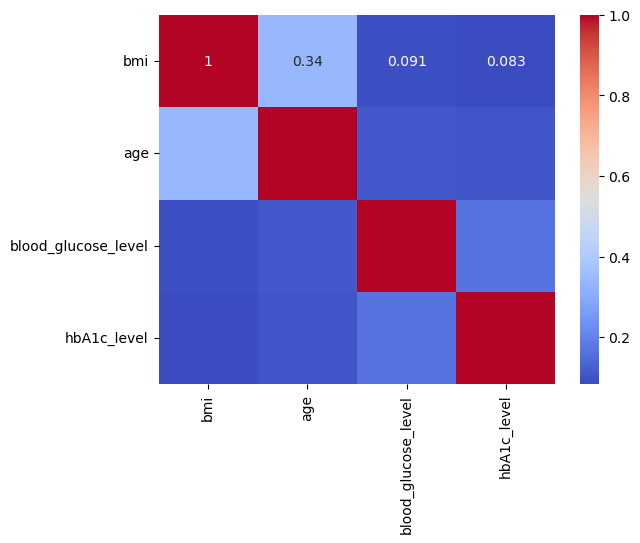

In [23]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

#### The heatmap shows that the variables in  dataset are not strongly correlated with each other. This suggests that no single variable among BMI, age, or blood glucose level alone has a strong linear relationship with the others.
#### The moderate correlation between BMI and age may suggest that older individuals tend to have higher BMIs, which is a common trend in many populations.

C:\Users\hem11\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\hem11\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


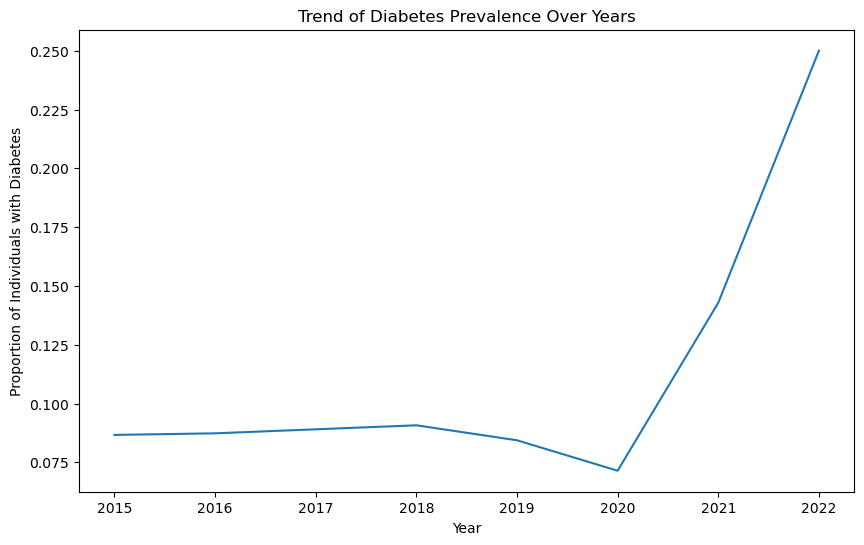

In [24]:
# Diabetes Prevelance over the years
# Group by year and calculate the proportion of individuals with diabetes
diabetes_trend = df2.groupby('year')['diabetes'].mean().reset_index()

# Line plot for diabetes trend over the years
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='diabetes', data=diabetes_trend)
plt.title('Trend of Diabetes Prevalence Over Years')
plt.ylabel('Proportion of Individuals with Diabetes')
plt.xlabel('Year')
plt.show()


## Stable Trend (2015-2019): The consistency in diabetes prevalence could indicate stable health management practices or healthcare access during these years.
## Dip in 2020: The drop in diabetes prevalence in 2020 might be an anomaly related to healthcare disruptions caused by the pandemic. Many people had less access to diagnostic services or routine check-ups, which could explain the lower reporting of diabetes.
## Sharp Increase in 2021-2022: The sharp increase in diabetes prevalence could be due to:
###  . Delayed diagnoses from the pandemic period being recorded post-2020.
###  . An actual increase in diabetes incidence due to lifestyle changes or increased stress during the pandemic years.
###  . Changes in healthcare policies or improvements in data reporting during these years.

C:\Users\hem11\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\hem11\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\hem11\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\hem11\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

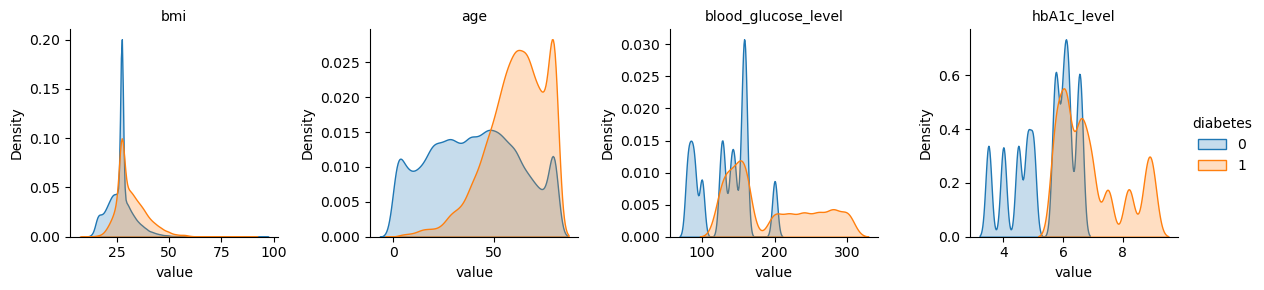

In [25]:
# FacetGrid with KDE to plot multiple distributions of continous variables

# Reshape data for FacetGrid
melted_data = df2.melt(id_vars='diabetes', value_vars=continous_columns)

# Create FacetGrid with KDE plots
g = sns.FacetGrid(melted_data, col='variable', hue='diabetes', sharex=False, sharey=False)
g.map(sns.kdeplot, 'value', fill=True) 
g.set_titles("{col_name}")
g.add_legend()

plt.show()


## Insights
### 1. BMI: Only a moderate relationship with diabetes, with higher BMIs slightly more common in the diabetic group.
### 2. Age: Older individuals are more likely to have diabetes, as seen by the rightward shift of the diabetic distribution.
### 3. Blood Glucose Level: This is a very strong indicator of diabetes, with diabetic individuals having significantly higher glucose levels.
### 4. HbA1c Level: Another strong indicator of diabetes, with diabetic individuals showing much higher HbA1c levels, aligning with clinical diagnostic thresholds.

C:\Users\hem11\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\hem11\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\hem11\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\hem11\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

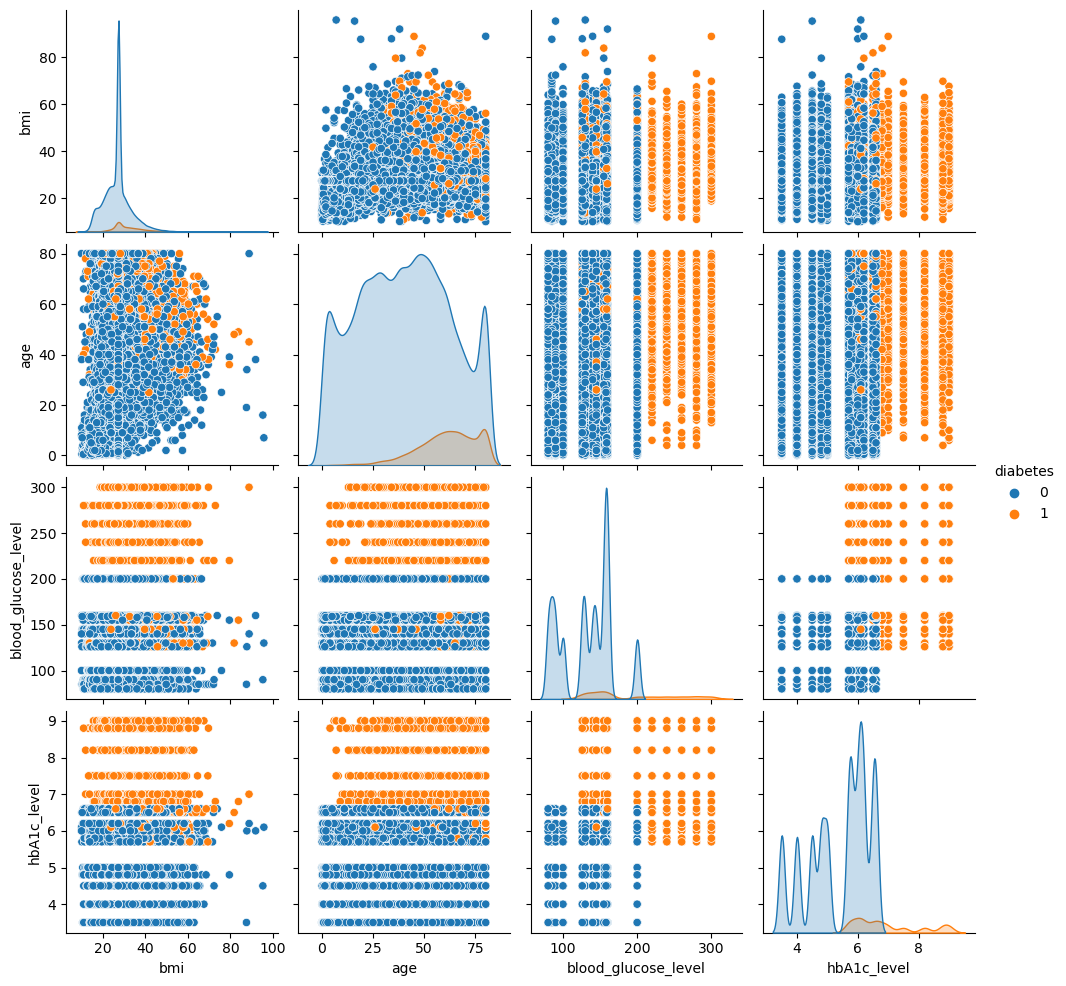

In [26]:
# Pair plot with KDE on diagonals and scatter plots on off-diagonals
sns.pairplot(df2[['bmi', 'age', 'blood_glucose_level','hbA1c_level', 'diabetes']], hue='diabetes', diag_kind='kde')
plt.show()


### Age and Diabetes: Diabetic individuals tend to be older, as seen from both the age distribution and the scatter plots comparing age to other variables.
### Blood Glucose and HbA1c: These are strong indicators of diabetes, with diabetic individuals showing much higher values compared to non-diabetic individuals.
### BMI: Although there is some difference between diabetic and non-diabetic groups, BMI shows a less clear distinction between these groups compared to blood glucose levels and HbA1c levels.

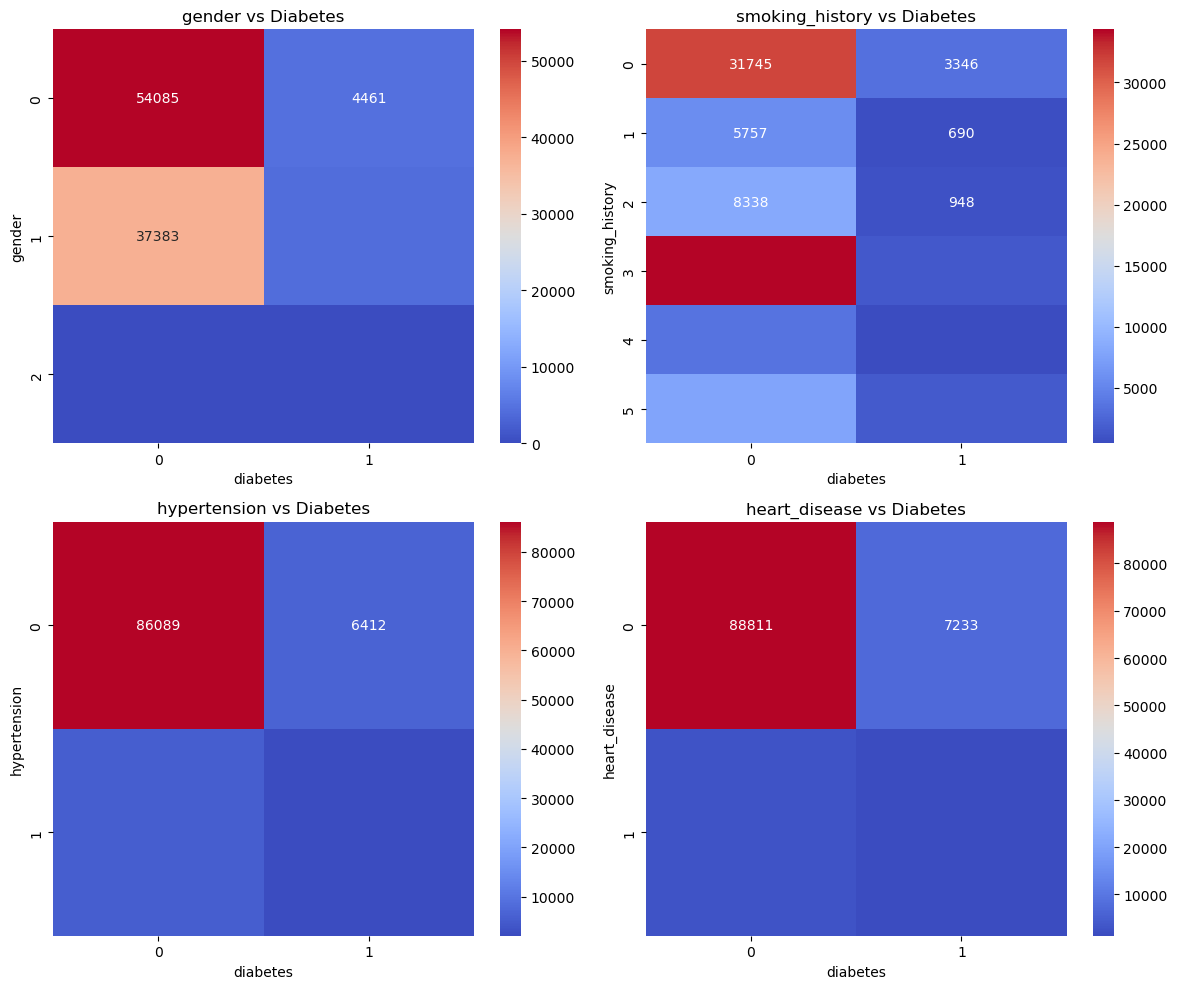

In [27]:
# List of variable combinations to explore
categorical_vars = ['gender', 'smoking_history', 'hypertension', 'heart_disease']

# Create a figure with subplots for each variable
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten axes for easier indexing
axes = axes.flatten()

# Loop through each categorical variable and plot a heatmap
for i, var in enumerate(categorical_vars):
    crosstab = pd.crosstab(df1[var], df1['diabetes'])
    sns.heatmap(crosstab, cmap='coolwarm', annot=True, fmt="d", ax=axes[i])
    axes[i].set_title(f'{var} vs Diabetes')

plt.tight_layout()
plt.show()



## Key Insights:
#### Gender: Males have a higher proportion of diabetes compared to females.
#### Smoking History: Non-smokers have more non-diabetics, but current smokers show a substantial number of diabetics.
#### Hypertension & Heart Disease: Both conditions are associated with higher proportions of diabetics compared to the non-diabetic population.

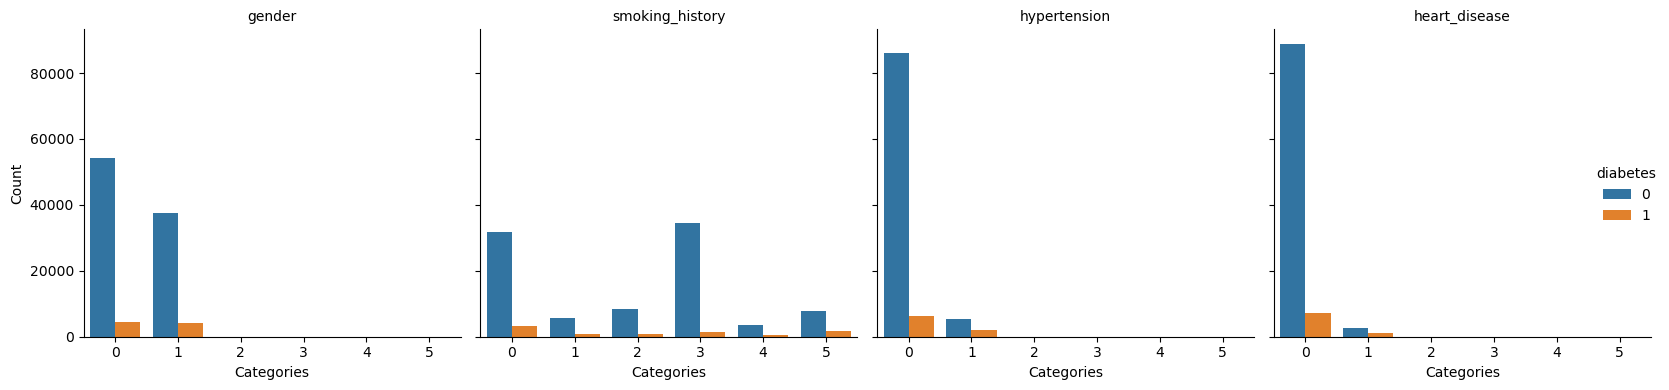

In [28]:
# Define categorical variables
categorical_vars = ['gender', 'smoking_history', 'hypertension', 'heart_disease']

# Convert categorical variables to strings in the original dataframe
df2[categorical_vars] = df1[categorical_vars].astype(str)

# Convert 'diabetes' column to string type to avoid the AttributeError
df2['diabetes'] = df1['diabetes'].astype(str)


# Melt the dataframe to handle multiple categorical variables in one plot
melted_data = df2.melt(id_vars='diabetes', value_vars=categorical_vars)

# Convert the 'value' column to string type to ensure compatibility
melted_data['value'] = melted_data['value'].astype(str)

# Create FacetGrid using Seaborn's catplot
g = sns.catplot(x='value', hue='diabetes', col='variable', data=melted_data, kind='count', height=4, aspect=1)

# Set axis labels and titles
g.set_axis_labels('Categories', 'Count')
g.set_titles('{col_name}')
plt.tight_layout()
plt.show()



### Hypertension and Heart Disease: These conditions are associated with a higher proportion of individuals with diabetes, as seen from the relatively larger orange bars in these categories.
### Smoking History: While most individuals have no smoking history, individuals in certain smoking categories (e.g., current or former smokers) show a higher proportion of diabetes.
### Gender: Gender doesn't seem to have a large effect on diabetes prevalence, with similar proportions of diabetic individuals across gender categories.

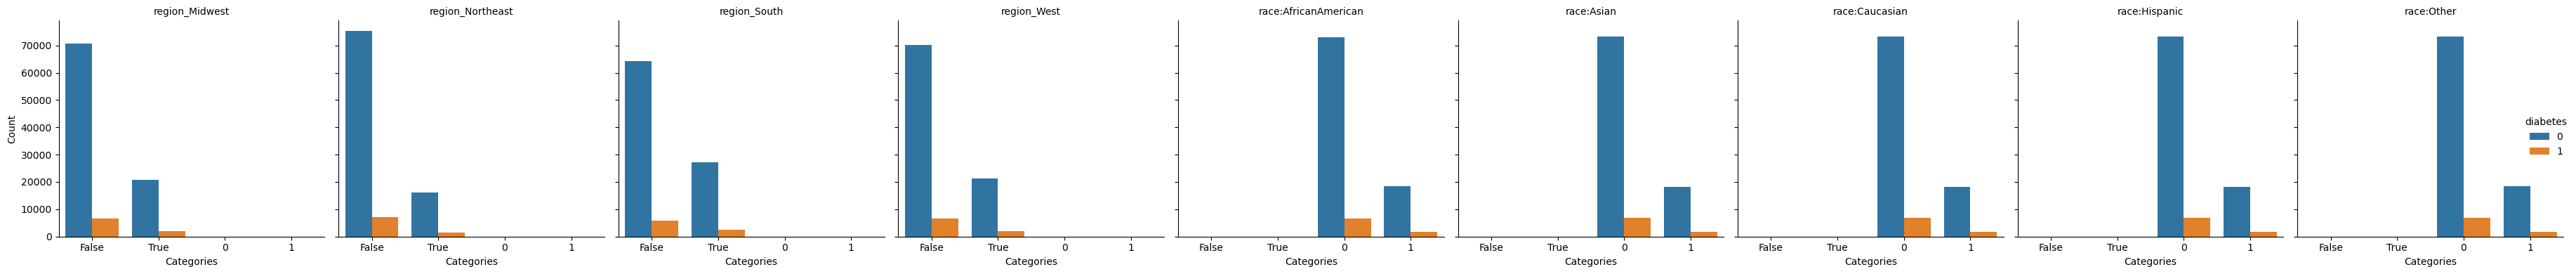

In [29]:
# Define categorical variables for race and regions
race_region_vars = ['region_Midwest','region_Northeast', 'region_South', 'region_West','race:AfricanAmerican','race:Asian',
                     'race:Caucasian','race:Hispanic','race:Other']

# Convert the categorical variables to string (if not already done)
df2[race_region_vars] = df1[race_region_vars].astype(str)

# Convert 'diabetes' to string to avoid any issues with the hue
df2['diabetes'] = df1['diabetes'].astype(str)

# Melt the dataframe to handle multiple categorical variables in one plot
melted_data_race_region = df2.melt(id_vars='diabetes', value_vars=race_region_vars)

# Create a FacetGrid for race and region variables
g = sns.catplot(x='value', hue='diabetes', col='variable', data=melted_data_race_region, kind='count', height=4, aspect=1)

# Set axis labels and titles
g.set_axis_labels('Categories', 'Count')
g.set_titles('{col_name}')
plt.tight_layout()
plt.show()


#### Regions: While the South and Midwest have more individuals with diabetes in absolute terms (due to their larger populations), the prevalence of diabetes (the proportion of diabetics within the population) is not necessarily higher. 
#### Race: African American and Hispanic populations show a higher proportion of diabetics compared to Asian and Caucasian populations. This suggests that diabetes might be more prevalent in African American and Hispanic groups, which aligns with known disparities in diabetes risk factors across racial groups.


### Prevalence is a term used in healthcare to describe the proportion of a population that has a specific condition or disease at a given point in time or over a specified period. It's essentially a measure of how common a disease or condition is within a particular population.
### Formula for Prevalence: Prevalence =( Number of people with the condition/Total number of people in the population)×100


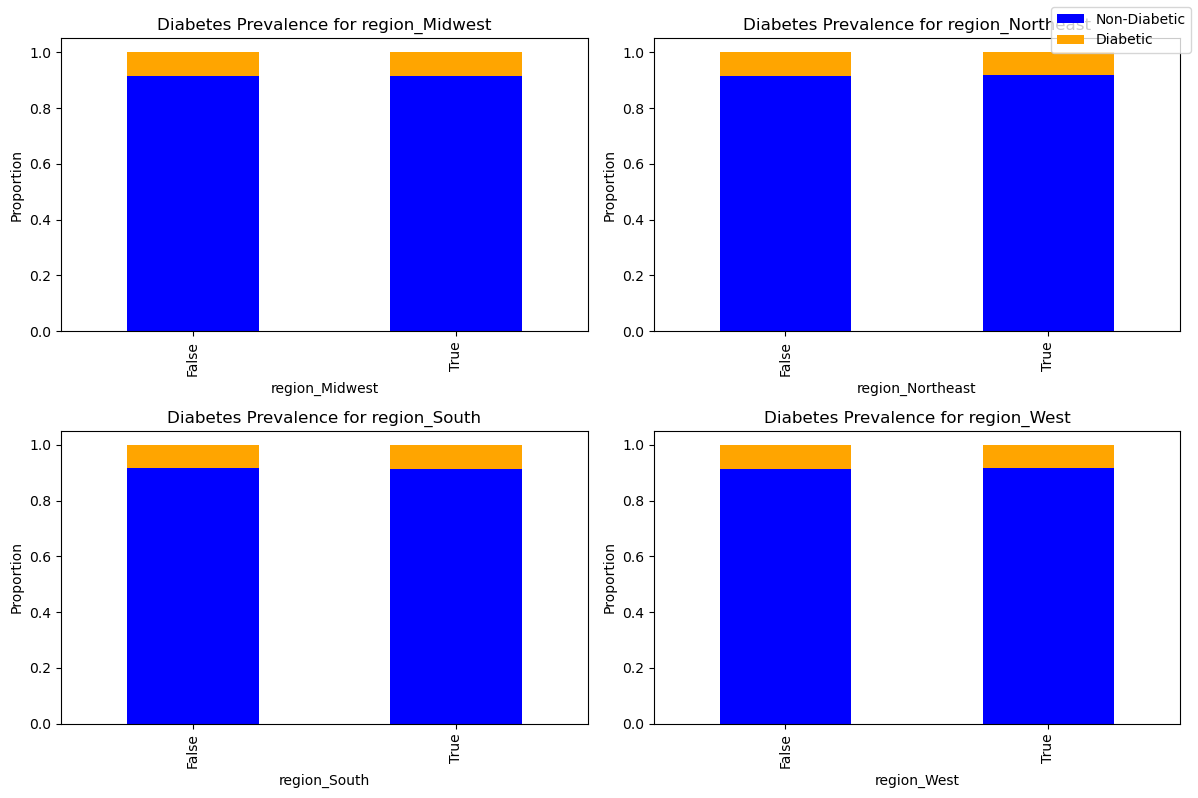

In [30]:

# List of region columns
region_columns = ['region_Midwest', 'region_Northeast', 'region_South', 'region_West']

# Create a figure with 2x2 subplots to fit all the graphs
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# Flatten the axes array to make indexing easier
axes = axes.flatten()

# Loop through each region and plot
for i, region in enumerate(region_columns):
    # Calculate the proportion of diabetics (1) and non-diabetics (0) in each region
    region_prevalence = df1.groupby(region)['diabetes'].value_counts(normalize=True).unstack(fill_value=0)

    # Plot both diabetic (1) and non-diabetic (0) individuals
    region_prevalence.plot(kind='bar', stacked=True, ax=axes[i], color=['blue', 'orange'], legend=False)

    # Set titles and labels for each subplot
    axes[i].set_title(f'Diabetes Prevalence for {region}')
    axes[i].set_ylabel('Proportion')
    axes[i].set_xlabel(region)

# Add a legend to differentiate diabetic and non-diabetic
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, ['Non-Diabetic', 'Diabetic'], loc='upper right')

plt.tight_layout()
plt.show()


#### The bars in the plot show the proportion of diabetics and non-diabetics in each region, and visually, the proportion of diabetics (orange) in each region looks quite similar.
#### This means that while there may be small differences in absolute numbers, the proportion of diabetics to non-diabetics is fairly consistent across regions.

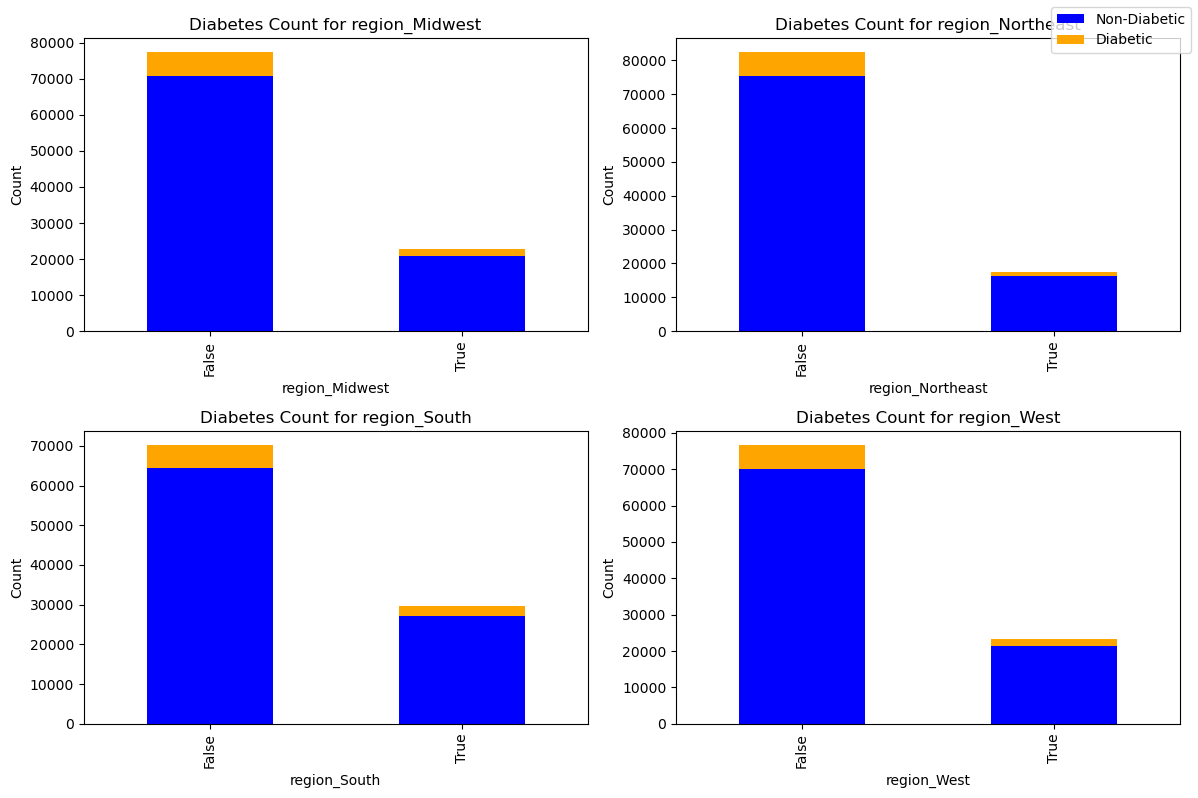

In [31]:
# Plot the absolute counts for diabetes in each region
# List of region columns
region_columns = ['region_Midwest', 'region_Northeast', 'region_South', 'region_West']

# Create a figure with 2x2 subplots to fit all the graphs
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# Flatten the axes array to make indexing easier
axes = axes.flatten()

# Loop through each region and plot absolute counts
for i, region in enumerate(region_columns):
    # Calculate the count of diabetics (1) and non-diabetics (0) in each region
    region_counts = df1.groupby(region)['diabetes'].value_counts().unstack(fill_value=0)

    # Plot both diabetic (1) and non-diabetic (0) individuals
    region_counts.plot(kind='bar', stacked=True, ax=axes[i], color=['blue', 'orange'], legend=False)

    # Set titles and labels for each subplot
    axes[i].set_title(f'Diabetes Count for {region}')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel(region)

# Add a legend to differentiate diabetic and non-diabetic
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, ['Non-Diabetic', 'Diabetic'], loc='upper right')

plt.tight_layout()
plt.show()

#### In all regions, the False group (i.e., individuals not from that region) is much larger in terms of absolute population size.
#### The True groups (individuals from each region) have smaller populations but a relatively higher proportion of diabetics, especially in the South and Midwest regions.

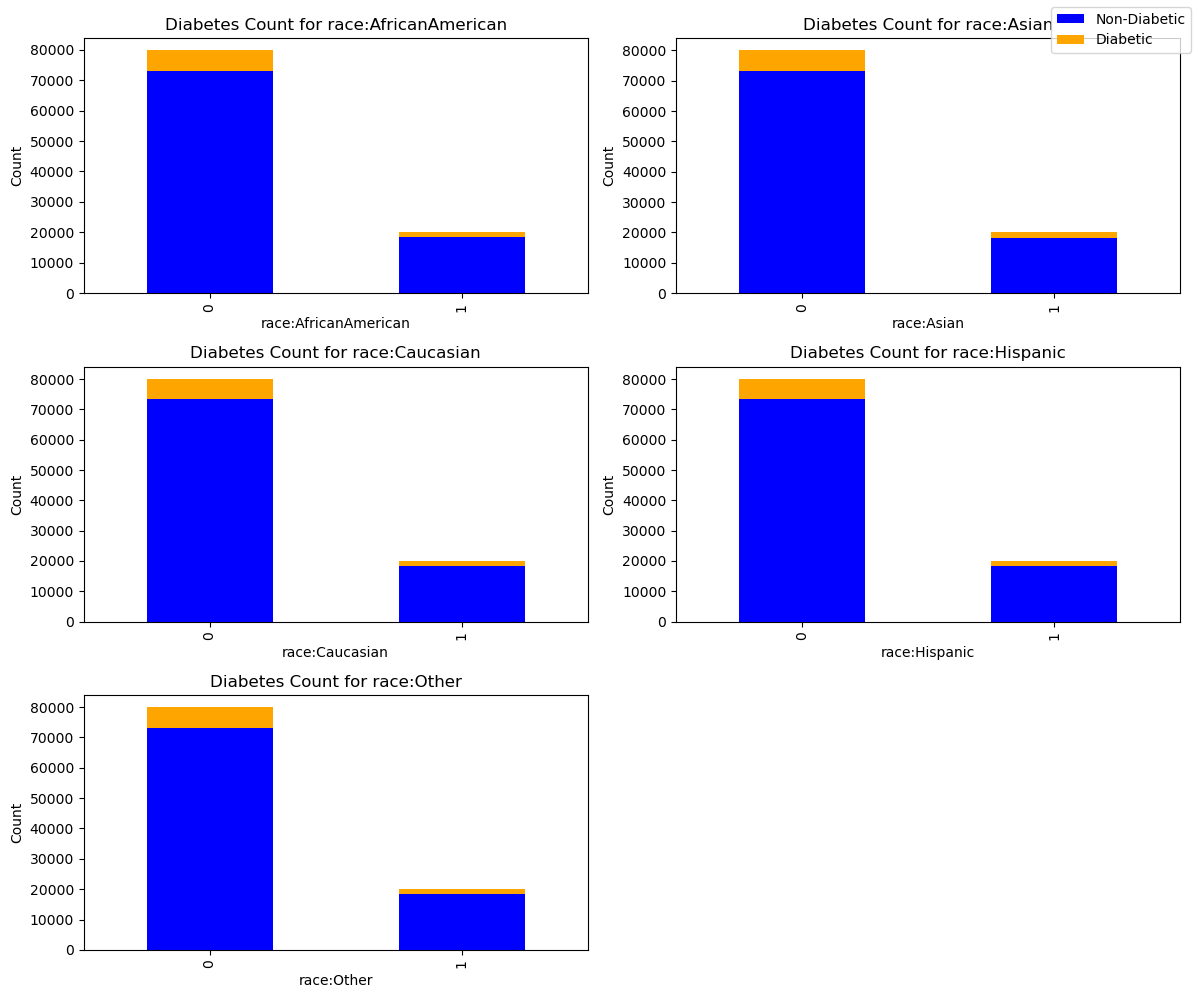

In [32]:
# List of race columns
race_columns = ['race:AfricanAmerican', 'race:Asian', 'race:Caucasian', 'race:Hispanic', 'race:Other']

# Create a figure with 3x2 subplots to fit all the graphs (adjusting grid size for 5 races)
fig, axes = plt.subplots(3, 2, figsize=(12, 10))  # 3 rows, 2 columns

# Flatten the axes array to make indexing easier
axes = axes.flatten()

# Loop through each race and plot
for i, race in enumerate(race_columns):
    # Calculate the absolute counts of diabetics (1) and non-diabetics (0) in each race
    race_counts = df1.groupby(race)['diabetes'].value_counts().unstack(fill_value=0)

    # Plot both diabetic (1) and non-diabetic (0) individuals
    race_counts.plot(kind='bar', stacked=True, ax=axes[i], color=['blue', 'orange'], legend=False)

    # Set titles and labels for each subplot
    axes[i].set_title(f'Diabetes Count for {race}')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel(race)

# Remove empty subplot if any (since there are 5 races and 6 grid slots)
fig.delaxes(axes[-1])

# Add a legend to differentiate diabetic and non-diabetic
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, ['Non-Diabetic', 'Diabetic'], loc='upper right')

plt.tight_layout()
plt.show()


#### For all race categories, the Non-Diabetic (blue) group is much larger than the Diabetic (orange) group. In terms of absolute numbers, each race group has a significantly higher non-diabetic population. There is some variation in the size of the diabetic populations, but visually, it seems consistent across the different race groups.

# Ouliers Detection

In [33]:
# Outlier detection function
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)].copy()  # Use .copy() to avoid SettingWithCopyWarning
    return outliers

# List of continuous variables for outlier detection
continuous_columns = ['age', 'bmi', 'blood_glucose_level', 'hbA1c_level']  # Replace with your actual continuous columns

# Outlier detection and counting
outliers_dict = {}
for var in continuous_columns:
    outliers = detect_outliers(df1, var)
    if not outliers.empty:  # Only proceed if outliers were detected
        outliers.loc[:, 'variable'] = var  # Use .loc[] to assign to a new column safely
        outliers_dict[var] = outliers
        # Print the count of outliers for each variable
        print(f"Outliers detected for {var}: {len(outliers)}")
    else:
        print(f"No outliers detected for {var}.")

# Concatenate the outliers for each variable into a single DataFrame for display
if outliers_dict:
    outliers_combined = pd.concat(outliers_dict.values(), ignore_index=True)
    # Display the combined DataFrame of outliers on screen
    print("Displaying the detected outliers:")
    print(outliers_combined.head())  # Display the first few rows for preview
    print(f"\nTotal outliers detected: {len(outliers_combined)}")

    # Optionally, export the outliers to a CSV file
    outliers_combined.to_csv(base_data_path + "Hemant_detected_outliers.csv", index=False)

    # Provide confirmation
    print("Outliers have been exported to 'Hemant_detected_outliers.csv'.")
else:
    print("No outliers detected in any of the variables.")


No outliers detected for age.
Outliers detected for bmi: 7086
Outliers detected for blood_glucose_level: 2038
Outliers detected for hbA1c_level: 1315
Displaying the detected outliers:
   year gender   age location  race:AfricanAmerican  race:Asian  \
0  2016      0  64.0  Alabama                     0           0   
1  2016      0  54.0  Alabama                     0           0   
2  2016      1  43.0  Alabama                     0           0   
3  2015      1  24.0  Alabama                     0           0   
4  2015      0  42.0  Alabama                     0           1   

   race:Caucasian  race:Hispanic  race:Other  hypertension  ...  \
0               0              0           1             0  ...   
1               0              0           1             0  ...   
2               1              0           0             0  ...   
3               0              1           0             0  ...   
4               0              0           0             0  ...   

   smoking

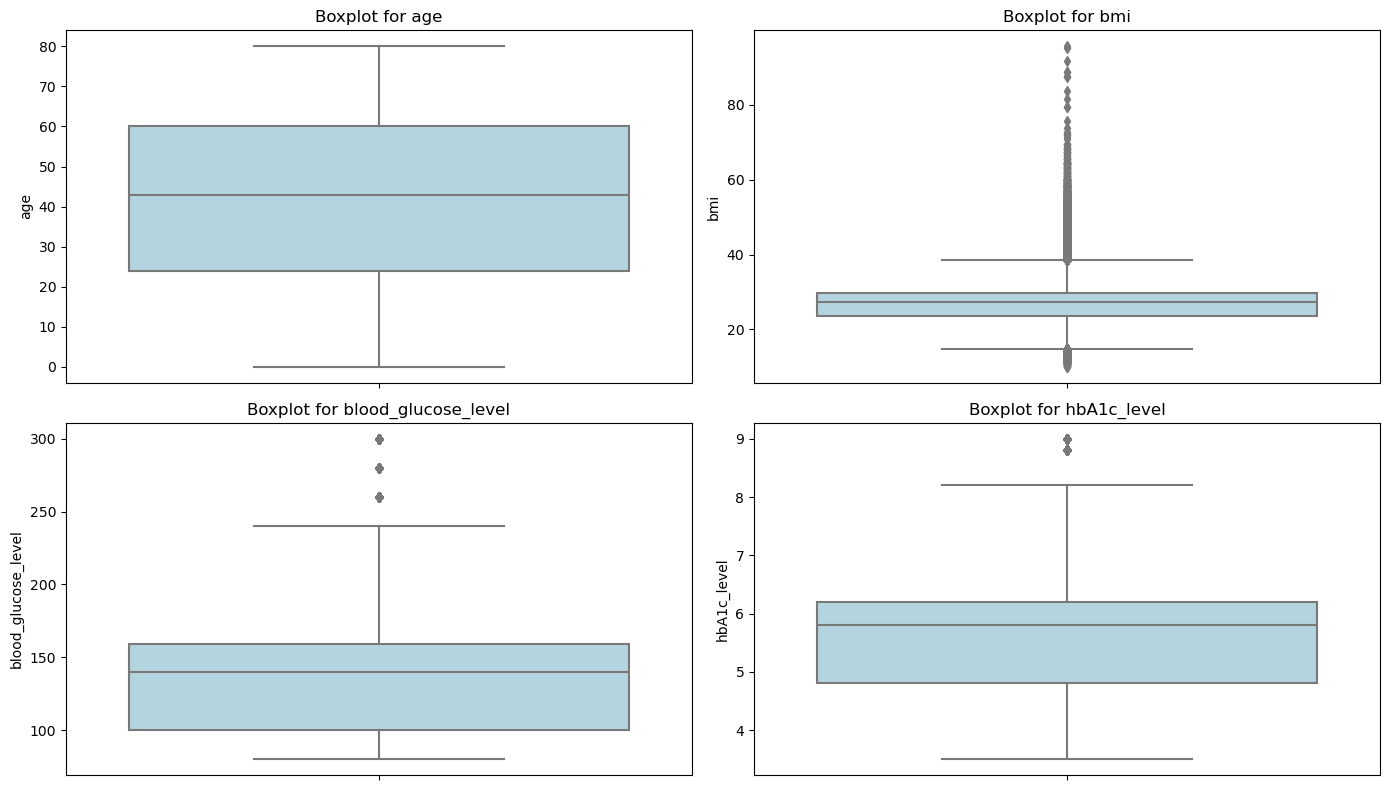

In [34]:
# Function to plot outliers using boxplots
def plot_outliers(df, continuous_columns):
    plt.figure(figsize=(14, 8))  # Set figure size
    for i, column in enumerate(continuous_columns):
        plt.subplot(2, 2, i + 1)  # Create subplots (2x2 for 4 continuous variables)
        sns.boxplot(data=df, y=column, color="lightblue")  # Plot boxplot
        plt.title(f"Boxplot for {column}")  # Set title for each plot
        plt.tight_layout()

# List of continuous variables for plotting
continuous_columns = ['age', 'bmi', 'blood_glucose_level', 'hbA1c_level']  # Update this as per your data

# Plot the outliers
plot_outliers(df1, continuous_columns)

plt.show()


### Age: No visible outlier
### BMI: Several outliers on both the lower and upper ends.These outliers might represent individuals with abnormally low or high BMIs, which may need further inspection or treatment in the model, as they can heavily influence the results.
### Blood Glucose Level: Few outliers exist above the upper whisker. These represent extreme blood glucose levels. Need to examine whether these represent measurement errors or extreme cases.
### HbA1c Level: Few outliers are also present, but overall, the distribution seems compact.It’s important to check if these extreme values are clinically valid or should be handled differently.

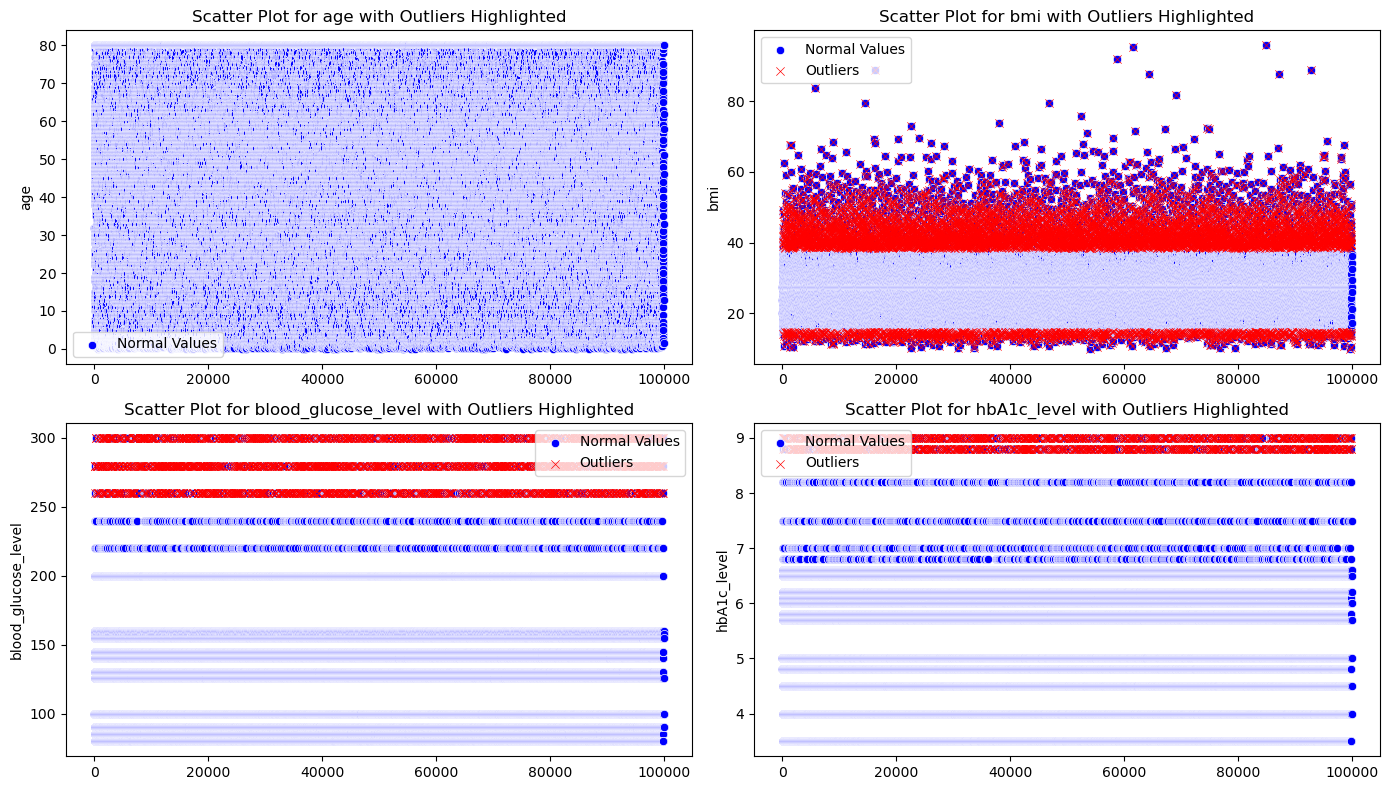

In [35]:
# Function to plot scatter plots with outliers highlighted
def plot_outliers_with_highlight(df, continuous_columns, outliers_dict):
    plt.figure(figsize=(14, 8))
    for i, column in enumerate(continuous_columns):
        plt.subplot(2, 2, i + 1)  # Create subplots (2x2 for 4 continuous variables)
        sns.scatterplot(data=df, x=df.index, y=column, label="Normal Values", color="blue")  # Scatter plot for all data
        if column in outliers_dict:  # Check if there are outliers for this column
            sns.scatterplot(data=outliers_dict[column], x=outliers_dict[column].index, y=column, label="Outliers", color="red", marker='x')  # Highlight outliers in red
        plt.title(f"Scatter Plot for {column} with Outliers Highlighted")
        plt.legend()
        plt.tight_layout()

# Plot scatter plots with outliers highlighted
plot_outliers_with_highlight(df1, continuous_columns, outliers_dict)

plt.show()


### Age: Distribution looks fairly uniform, no significant outliers detected.
### BMI: Significant outliers exist, especially above the normal BMI range (> 40). These outliers appear in the upper bound, which could indicate individuals with extremely high BMI values.These individuals might require special consideration, such as applying transformations or handling them separately in the model.
### Blood Glucose Level: Several outliers are visible in the upper glucose levels (> 250). These extreme values could be valid (e.g., individuals with hyperglycemia), but it’s crucial to validate whether these are errors or true cases. If the outliers are deemed valid, we can choose to keep them, but if they appear due to errors, we might need to remove or adjust them.
### HbA1c Level: Few outliers, but the range is relatively compact.The extreme HbA1c values (> 8) could be clinically significant and may not necessarily need to be treated as outliers.

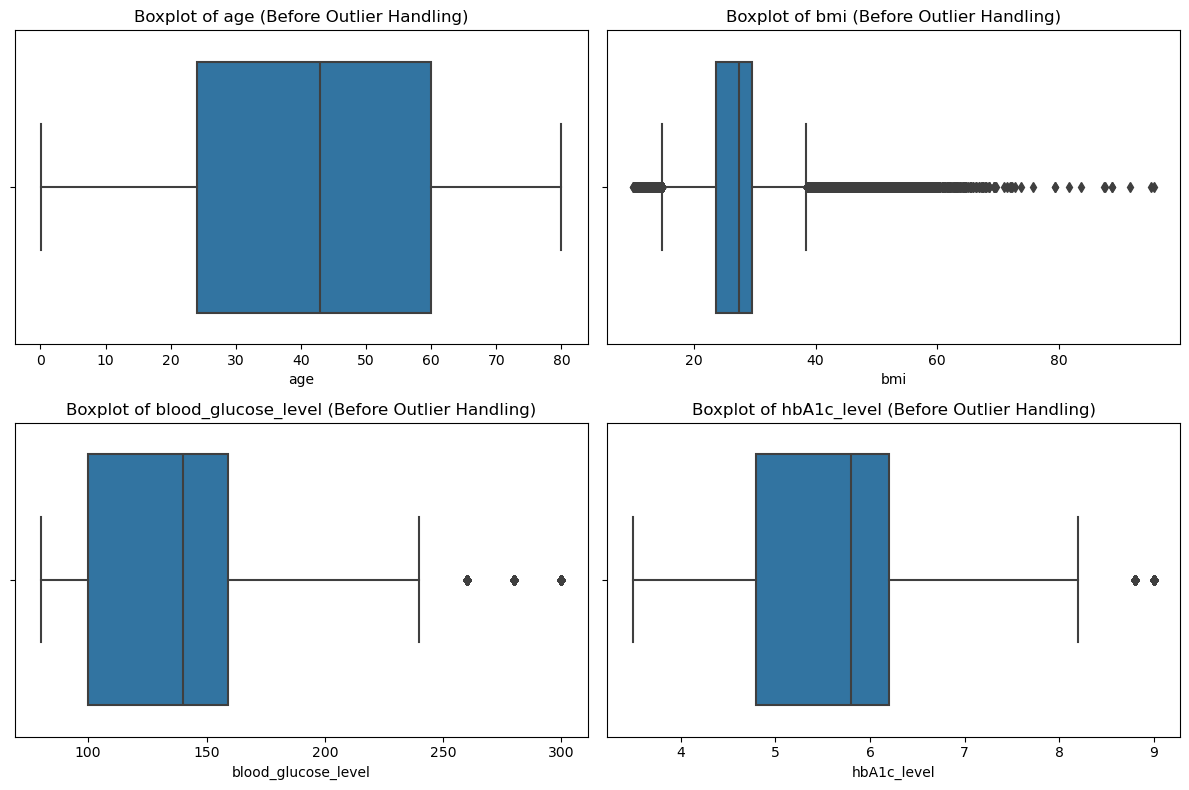

In [36]:
# List of continuous variables
continuous_columns = ['age', 'bmi', 'blood_glucose_level', 'hbA1c_level']

# Create a 2x2 grid of box plots for visualizing outliers before handling
plt.figure(figsize=(12, 8))
for i, col in enumerate(continuous_columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df1[col])
    plt.title(f'Boxplot of {col} (Before Outlier Handling)')
plt.tight_layout()
plt.show()


In [37]:
# Function to handle outliers in the BMI column using the IQR method
def handle_bmi_outliers(df):
    Q1 = df['bmi'].quantile(0.25)
    Q3 = df['bmi'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Cap the BMI outliers at the lower and upper bounds
    df['bmi'] = np.clip(df['bmi'], lower_bound, upper_bound)
    return df

# Apply the outlier handling to BMI only
df1 = handle_bmi_outliers(df1)

# Check the effect of handling BMI outliers
df1['bmi'].describe()


count    99986.000000
mean        26.991640
std          5.671824
min         14.705000
25%         23.630000
50%         27.320000
75%         29.580000
max         38.505000
Name: bmi, dtype: float64

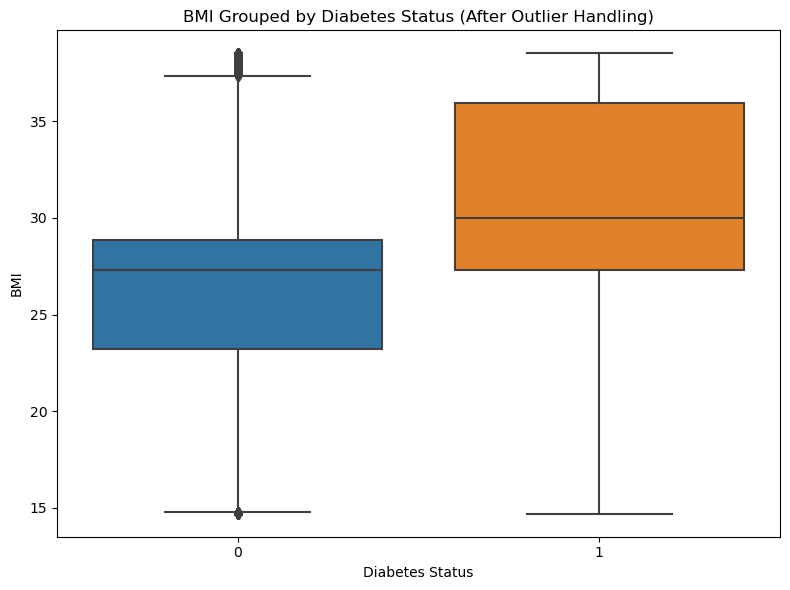

In [38]:
# Create a box plot for BMI, grouped by diabetes status after outlier handling
plt.figure(figsize=(8, 6))
sns.boxplot(x='diabetes', y='bmi', data=df1)

# Set the title and labels
plt.title('BMI Grouped by Diabetes Status (After Outlier Handling)')
plt.xlabel('Diabetes Status')
plt.ylabel('BMI')

# Show the plot
plt.tight_layout()
plt.show()


In [39]:
# Check if there are any NaN values in the gender column
print(df1['gender'].isnull().sum())

# Display unique values in gender to ensure mapping works correctly
print(df1['gender'].unique())
df1.head()

0
[0 1 2]


,year,gender,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes,region_Midwest,region_Northeast,region_South,region_West
0,2020,0,32.0,Alabama,0,0,0,0,1,0,0,0,27.32,5.0,100,0,False,False,True,False
1,2015,0,29.0,Alabama,0,1,0,0,0,0,0,0,19.95,5.0,90,0,False,False,True,False
2,2015,1,18.0,Alabama,0,0,0,0,1,0,0,0,23.76,4.8,160,0,False,False,True,False
3,2015,1,41.0,Alabama,0,0,1,0,0,0,0,0,27.32,4.0,159,0,False,False,True,False
4,2016,0,52.0,Alabama,1,0,0,0,0,0,0,0,23.75,6.5,90,0,False,False,True,False


In [40]:
# Initialize the KFold cross-validation for target encoding
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define categorical columns for target encoding (excluding gender since it's already encoded)
categorical_columns = ['smoking_history', 'hypertension', 'heart_disease',
                       'region_Midwest', 'region_Northeast', 'region_South', 'region_West',
                       'race:AfricanAmerican', 'race:Asian', 'race:Caucasian', 'race:Hispanic', 'race:Other']

# Initialize the dataframe to store the out-of-fold encoded values
df_encoded_cv = df1.copy()

# Since gender is already encoded, we skip any transformation for this column

# Initialize a DataFrame to store the encoded categorical columns
encoded_df = pd.DataFrame(index=df1.index)

# Initialize target encoder with smoothing for the remaining categorical columns
target_encoder = ce.TargetEncoder(cols=categorical_columns, smoothing=1.0)

# Cross-validation loop for target encoding
for train_idx, val_idx in kf.split(df1):
    X_train, X_val = df1.iloc[train_idx], df1.iloc[val_idx]
    
    # Fit the target encoder on the training fold (without using the validation fold)
    target_encoder.fit(X_train[categorical_columns], X_train['diabetes'])
    
    # Transform the validation fold and store only the transformed columns
    encoded_df.iloc[val_idx] = target_encoder.transform(X_val[categorical_columns])

# After encoding all folds, transform the entire dataset (optional)
encoded_full_dataset = target_encoder.fit_transform(df1[categorical_columns], df1['diabetes'])

# Add encoded features to the original dataframe (excluding gender)
df_encoded_cv[categorical_columns] = encoded_full_dataset

# Now the encoded DataFrame is ready
df_encoded_cv.head()

# Convert 'gender' column back to integer (if that's how it was initially intended)
df_encoded_cv['gender'] = pd.to_numeric(df_encoded_cv['gender'], errors='coerce')


In [41]:
# Display the first few rows of the updated DataFrame
print(df_encoded_cv.head())

# If you prefer to inspect it in more detail, use the following:
df_encoded_cv.to_csv("updated_df_encoded_cv.csv", index=False)

   year  gender   age location  race:AfricanAmerican  race:Asian  \
0  2020       0  32.0  Alabama              0.084398    0.084485   
1  2015       0  29.0  Alabama              0.084398    0.087120   
2  2015       1  18.0  Alabama              0.084398    0.084485   
3  2015       1  41.0  Alabama              0.084398    0.084485   
4  2016       0  52.0  Alabama              0.087434    0.084485   

   race:Caucasian  race:Hispanic  race:Other  hypertension  heart_disease  \
0        0.085255       0.085195    0.082158      0.069318       0.075309   
1        0.085255       0.085195    0.085725      0.069318       0.075309   
2        0.085255       0.085195    0.082158      0.069318       0.075309   
3        0.084034       0.085195    0.085725      0.069318       0.075309   
4        0.085255       0.085195    0.085725      0.069318       0.075309   

   smoking_history    bmi  hbA1c_level  blood_glucose_level  diabetes  \
0         0.095352  27.32          5.0                 

In [42]:
# Checking the data types of categorical columns to ensure proper encoding
df_encoded_cv.dtypes


year                      int64
gender                    int64
age                     float64
location                 object
race:AfricanAmerican    float64
race:Asian              float64
race:Caucasian          float64
race:Hispanic           float64
race:Other              float64
hypertension            float64
heart_disease           float64
smoking_history         float64
bmi                     float64
hbA1c_level             float64
blood_glucose_level       int64
diabetes                  int64
region_Midwest          float64
region_Northeast        float64
region_South            float64
region_West             float64
dtype: object

In [43]:
# Define the columns for feature interaction
categorical_columns = ['gender', 'smoking_history', 'hypertension', 'heart_disease', 
                       'region_Midwest', 'region_Northeast', 'region_South', 'region_West', 
                       'race:AfricanAmerican', 'race:Asian', 'race:Caucasian', 'race:Hispanic', 'race:Other']

continuous_columns = ['age', 'bmi', 'hbA1c_level', 'blood_glucose_level']

# Create a copy of the df_encoded_cv to store the interaction terms
interaction_df = df_encoded_cv.copy()

# Loop through each pair of categorical and continuous variables and create interaction terms
for cat_col in categorical_columns:
    for cont_col in continuous_columns:
        interaction_col = f"{cat_col}_x_{cont_col}"  # Create a new column name for the interaction term
        interaction_df[interaction_col] = interaction_df[cat_col] * interaction_df[cont_col]

# Inspect the first few rows with the interaction terms
interaction_df.head()


,year,gender,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,...,race:Caucasian_x_hbA1c_level,race:Caucasian_x_blood_glucose_level,race:Hispanic_x_age,race:Hispanic_x_bmi,race:Hispanic_x_hbA1c_level,race:Hispanic_x_blood_glucose_level,race:Other_x_age,race:Other_x_bmi,race:Other_x_hbA1c_level,race:Other_x_blood_glucose_level
0,2020,0,32.0,Alabama,0.084398,0.084485,0.085255,0.085195,0.082158,0.069318,...,0.426273,8.525458,2.726226,2.327516,0.425973,8.519457,2.629063,2.244562,0.410791,8.215822
1,2015,0,29.0,Alabama,0.084398,0.087120,0.085255,0.085195,0.085725,0.069318,...,0.426273,7.672912,2.470643,1.699632,0.425973,7.667511,2.486035,1.710221,0.428627,7.715282
2,2015,1,18.0,Alabama,0.084398,0.084485,0.085255,0.085195,0.082158,0.069318,...,0.409222,13.640732,1.533502,2.024223,0.408934,13.631131,1.478848,1.952079,0.394359,13.145315
3,2015,1,41.0,Alabama,0.084398,0.084485,0.084034,0.085195,0.085725,0.069318,...,0.336134,13.361345,3.492977,2.327516,0.340778,13.545937,3.514740,2.342017,0.342901,13.630332
4,2016,0,52.0,Alabama,0.087434,0.084485,0.085255,0.085195,0.085725,0.069318,...,0.554155,7.672912,4.430118,2.023371,0.553765,7.667511,4.457719,2.035977,0.557215,7.715282


In [44]:
# Define bins and labels for blood glucose level
bins_glucose = [0, 70, 99, 125, float('inf')]
labels_glucose = ['Low', 'Normal', 'Pre-diabetes', 'Diabetes']
df_encoded_cv['binned_blood_glucose'] = pd.cut(df_encoded_cv['blood_glucose_level'], bins=bins_glucose, labels=labels_glucose)

# Define bins and labels for HbA1c level (including severe diabetes)
bins_hba1c = [0, 5.7, 6.4, 7.9, float('inf')]
labels_hba1c = ['Normal', 'Pre-diabetes', 'Moderate Diabetes', 'Severe Diabetes']
df_encoded_cv['binned_hba1c'] = pd.cut(df_encoded_cv['hbA1c_level'], bins=bins_hba1c, labels=labels_hba1c)

# Define bins and labels for age (including infants and child)
bins_age = [0, 1, 12, 19, 35, 50, 70, float('inf')]
labels_age = ['Infants', 'Child', 'Teenager', 'Young Adult', 'Middle-Aged Adult', 'Older Adult', 'Senior']
df_encoded_cv['binned_age'] = pd.cut(df_encoded_cv['age'], bins=bins_age, labels=labels_age)

# Define bins and labels for BMI
bins_bmi = [0, 18.5, 24.9, 29.9, float('inf')]
labels_bmi = ['Underweight', 'Normal weight', 'Overweight', 'Obese']
df_encoded_cv['binned_bmi'] = pd.cut(df_encoded_cv['bmi'], bins=bins_bmi, labels=labels_bmi)

# Display the first few rows to confirm binning
df_encoded_cv[['age', 'binned_age', 'bmi', 'binned_bmi', 'blood_glucose_level', 'binned_blood_glucose', 'hbA1c_level', 'binned_hba1c']].head()


,age,binned_age,bmi,binned_bmi,blood_glucose_level,binned_blood_glucose,hbA1c_level,binned_hba1c
0,32.0,Young Adult,27.32,Overweight,100,Pre-diabetes,5.0,Normal
1,29.0,Young Adult,19.95,Normal weight,90,Normal,5.0,Normal
2,18.0,Teenager,23.76,Normal weight,160,Diabetes,4.8,Normal
3,41.0,Middle-Aged Adult,27.32,Overweight,159,Diabetes,4.0,Normal
4,52.0,Older Adult,23.75,Normal weight,90,Normal,6.5,Moderate Diabetes


In [45]:
# Initialize DataFrame for domain-specific features
df_domain_specific = df_encoded_cv.copy()

# 1. Age-BMI Interaction
df_domain_specific['age_bmi_interaction'] = df_domain_specific['age'] * df_domain_specific['bmi']

# 2. BMI Risk Score (Use existing binned BMI)
bmi_risk_mapping = {
    'Underweight': 1,
    'Normal weight': 2,
    'Overweight': 3,
    'Obese': 4
}
df_domain_specific['bmi_risk_score'] = df_domain_specific['binned_bmi'].map(bmi_risk_mapping).astype(float)

# 3. Age-Specific Risk Score (Use existing binned Age)
age_risk_mapping = {
    'Infants': 1,
    'Child': 2,
    'Teenager': 3,
    'Young Adult': 4,
    'Middle-Aged Adult': 5,
    'Older Adult': 6,
    'Senior': 7
}
df_domain_specific['age_risk_score'] = df_domain_specific['binned_age'].map(age_risk_mapping).astype(float)

# 4. Blood Glucose Risk Score (Use existing binned blood glucose)
blood_glucose_risk_mapping = {
    'Low': 1,
    'Normal': 2,
    'Pre-diabetes': 3,
    'Diabetes': 4
}
df_domain_specific['blood_glucose_risk_score'] = df_domain_specific['binned_blood_glucose'].map(blood_glucose_risk_mapping).astype(float)

# 5. HbA1c Risk Score (Use existing binned HbA1c)
hba1c_risk_mapping = {
    'Normal': 1,
    'Pre-diabetes': 2,
    'Moderate Diabetes': 3,
    'Severe Diabetes': 4
}
df_domain_specific['hba1c_risk_score'] = df_domain_specific['binned_hba1c'].map(hba1c_risk_mapping).astype(float)

# 6. Hypertension-Diabetes Interaction
df_domain_specific['hypertension_diabetes_interaction'] = df_domain_specific['hypertension'] * df_domain_specific['diabetes']

# 7. Interaction Terms with Regions and Smoking History
for region_col in ['region_Midwest', 'region_Northeast', 'region_South', 'region_West']:
    interaction_col = f'smoking_{region_col}_interaction'
    df_domain_specific[interaction_col] = df_domain_specific['smoking_history'] * df_domain_specific[region_col]

# 8. Hypertension-Heart Disease Interaction
df_domain_specific['hypertension_heart_interaction'] = df_domain_specific['hypertension'] * df_domain_specific['heart_disease']

# 9. Age-BMI-Hypertension Interaction
df_domain_specific['age_bmi_hypertension_interaction'] = df_domain_specific['age_bmi_interaction'] * df_domain_specific['hypertension']

# 10. Total Risk Score (Aggregate risk scores)
df_domain_specific['total_risk_score'] = (
    df_domain_specific['bmi_risk_score'] +
    df_domain_specific['age_risk_score'] +
    df_domain_specific['blood_glucose_risk_score'] +
    df_domain_specific['hba1c_risk_score'] +
    df_domain_specific['hypertension_diabetes_interaction'] +
    df_domain_specific['hypertension_heart_interaction']
)

# Display the updated DataFrame with combined interaction and risk scores
df_domain_specific.head()


,year,gender,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,...,blood_glucose_risk_score,hba1c_risk_score,hypertension_diabetes_interaction,smoking_region_Midwest_interaction,smoking_region_Northeast_interaction,smoking_region_South_interaction,smoking_region_West_interaction,hypertension_heart_interaction,age_bmi_hypertension_interaction,total_risk_score
0,2020,0,32.0,Alabama,0.084398,0.084485,0.085255,0.085195,0.082158,0.069318,...,3.0,1.0,0.0,0.00811,0.008162,0.008248,0.008129,0.00522,60.600717,11.00522
1,2015,0,29.0,Alabama,0.084398,0.087120,0.085255,0.085195,0.085725,0.069318,...,2.0,1.0,0.0,0.00811,0.008162,0.008248,0.008129,0.00522,40.104027,9.00522
2,2015,1,18.0,Alabama,0.084398,0.084485,0.085255,0.085195,0.082158,0.069318,...,4.0,1.0,0.0,0.00811,0.008162,0.008248,0.008129,0.00522,29.645995,10.00522
3,2015,1,41.0,Alabama,0.084398,0.084485,0.084034,0.085195,0.085725,0.069318,...,4.0,1.0,0.0,0.00811,0.008162,0.008248,0.008129,0.00522,77.644668,13.00522
4,2016,0,52.0,Alabama,0.087434,0.084485,0.085255,0.085195,0.085725,0.069318,...,2.0,3.0,0.0,0.00811,0.008162,0.008248,0.008129,0.00522,85.607939,13.00522


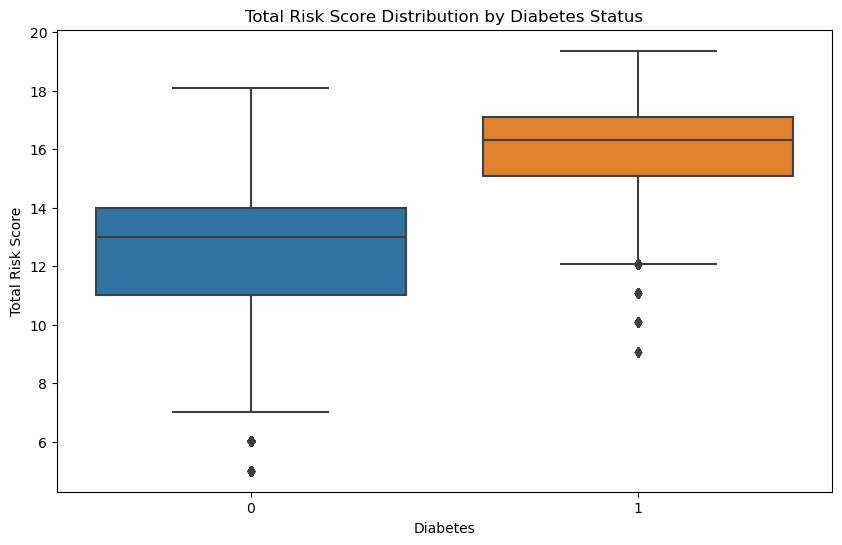

In [46]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='diabetes', y='total_risk_score', data=df_domain_specific)
plt.title('Total Risk Score Distribution by Diabetes Status')
plt.xlabel('Diabetes')
plt.ylabel('Total Risk Score')
plt.show()


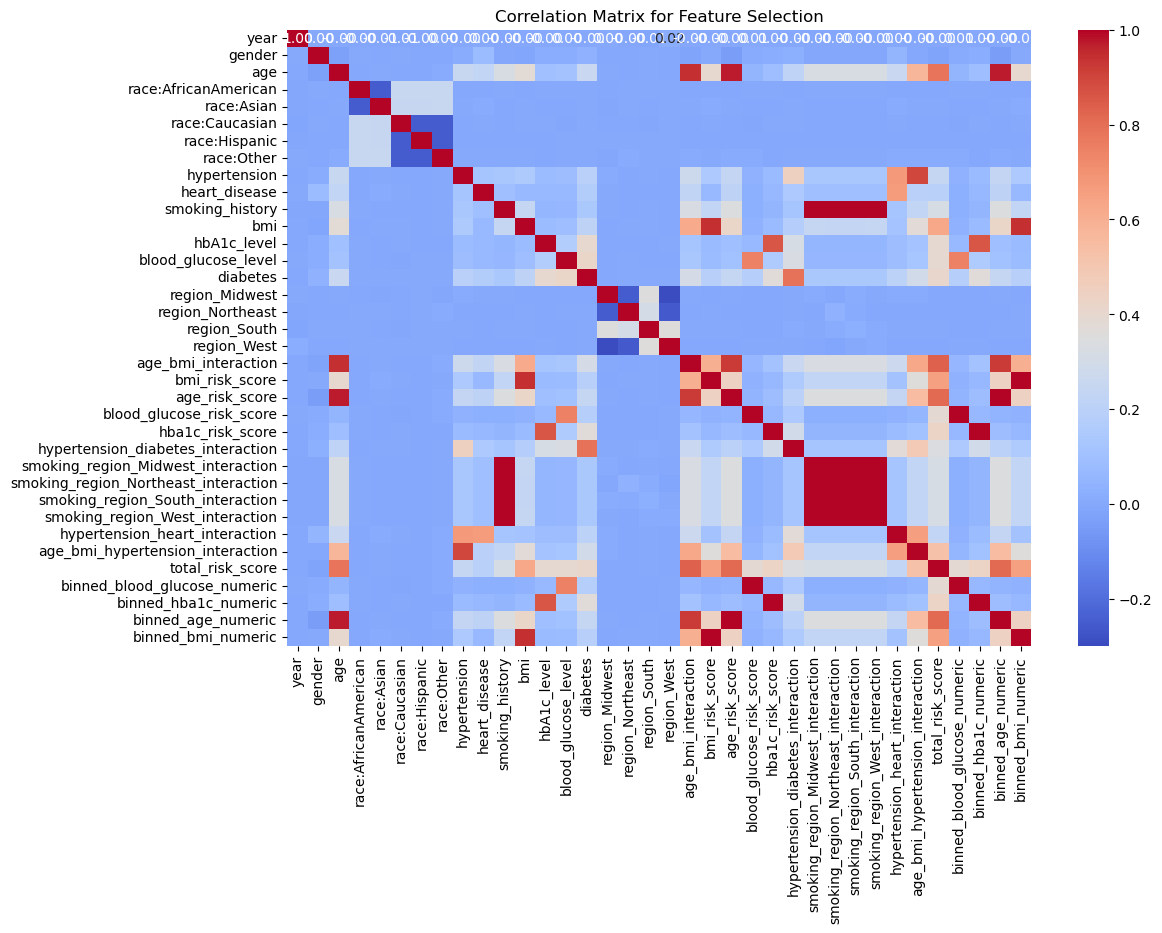

,year,gender,age,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,...,smoking_region_Northeast_interaction,smoking_region_South_interaction,smoking_region_West_interaction,hypertension_heart_interaction,age_bmi_hypertension_interaction,total_risk_score,binned_blood_glucose_numeric,binned_hba1c_numeric,binned_age_numeric,binned_bmi_numeric
0,2020,0,32.0,0.084398,0.084485,0.085255,0.085195,0.082158,0.069318,0.075309,...,0.008162,0.008248,0.008129,0.00522,60.600717,11.00522,3,1,4,3
1,2015,0,29.0,0.084398,0.087120,0.085255,0.085195,0.085725,0.069318,0.075309,...,0.008162,0.008248,0.008129,0.00522,40.104027,9.00522,2,1,4,2
2,2015,1,18.0,0.084398,0.084485,0.085255,0.085195,0.082158,0.069318,0.075309,...,0.008162,0.008248,0.008129,0.00522,29.645995,10.00522,4,1,3,2
3,2015,1,41.0,0.084398,0.084485,0.084034,0.085195,0.085725,0.069318,0.075309,...,0.008162,0.008248,0.008129,0.00522,77.644668,13.00522,4,1,5,3
4,2016,0,52.0,0.087434,0.084485,0.085255,0.085195,0.085725,0.069318,0.075309,...,0.008162,0.008248,0.008129,0.00522,85.607939,13.00522,2,3,6,2


In [47]:
# Define binned columns to be mapped to numeric values
binned_columns = ['binned_blood_glucose', 'binned_hba1c', 'binned_age', 'binned_bmi']

# Define mapping dictionaries for each binned variable
blood_glucose_mapping = {'Low': 1, 'Normal': 2, 'Pre-diabetes': 3, 'Diabetes': 4}
hba1c_mapping = {'Normal': 1, 'Pre-diabetes': 2, 'Moderate Diabetes': 3, 'Severe Diabetes': 4}
age_mapping = {'Infants': 1, 'Child': 2, 'Teenager': 3, 'Young Adult': 4, 'Middle-Aged Adult': 5, 'Older Adult': 6, 'Senior': 7}
bmi_mapping = {'Underweight': 1, 'Normal weight': 2, 'Overweight': 3, 'Obese': 4}

# Apply the mappings to convert the binned columns to numeric
df_domain_specific['binned_blood_glucose_numeric'] = df_domain_specific['binned_blood_glucose'].map(blood_glucose_mapping)
df_domain_specific['binned_hba1c_numeric'] = df_domain_specific['binned_hba1c'].map(hba1c_mapping)
df_domain_specific['binned_age_numeric'] = df_domain_specific['binned_age'].map(age_mapping)
df_domain_specific['binned_bmi_numeric'] = df_domain_specific['binned_bmi'].map(bmi_mapping)

# Now, drop the original categorical binned columns and any non-numeric columns
df_numeric = df_domain_specific.drop(columns=binned_columns + ['location'])

# Calculate the correlation matrix on the numeric DataFrame
correlation_matrix = df_numeric.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for Feature Selection')
plt.show()

# Display the numeric DataFrame to confirm changes
df_numeric.head()



#### 1. Strong Positive Correlations:
#### Binned Age and Age Risk Score: As expected, there is a strong positive correlation between the binned_age_numeric and age_risk_score. This makes sense since the age_risk_score is derived from the age bins.
#### Binned BMI and BMI Risk Score: Similar to the age feature, binned_bmi_numeric has a strong positive correlation with bmi_risk_score, as this score is derived directly from the binned BMI values.
#### Blood Glucose Binned and Blood Glucose Risk Score: The high correlation here is intuitive, as the binned_blood_glucose_numeric values directly contribute to the blood_glucose_risk_score.

#### 2. Interaction Terms:
#### Age-BMI Interaction and Age-BMI-Hypertension Interaction: These terms are highly correlated as one is derived from the other. Both features capture important interaction effects but having both might introduce redundancy.
#### Smoking Interaction with Regions: There is notable correlation between interaction terms like smoking_region_Midwest_interaction and other region-related interaction terms. This suggests potential overlap in information regarding region and smoking history.

#### 3. Redundancies:
#### Region Interactions: There are some correlations between different region interaction terms. For instance, smoking_region_Midwest_interaction correlates with smoking_region_Northeast_interaction. This could indicate some redundancy in the data when multiple region interaction terms are considered together.
#### Low Correlation with the Target (Diabetes):
#### Total Risk Score and Diabetes: The correlation between total_risk_score and diabetes is reasonably positive, though not extremely strong. This suggests the need for further exploration into other features or interactions.
##### Binned Variables and Diabetes: Features like binned_bmi_numeric, binned_blood_glucose_numeric, and binned_hba1c_numeric do not exhibit strong correlations with the diabetes variable. However, they still offer meaningful domain-specific information.

#### 4. Possible Issues:
##### Some features, such as year or the region-related interaction terms, show very low correlation with diabetes and could potentially be removed or reassessed. Low correlations with the target variable may suggest limited predictive power for those features.

#### Key Observations
#### 1. The interaction terms (e.g., age_bmi_interaction, hypertension_diabetes_interaction, smoking_region_*_interaction) show medium-to-high correlations with certain risk scores, which suggests that interactions between key variables are important for understanding the risk of diabetes.
#### 2. Age and BMI: Age and BMI-related features, particularly their risk scores, show higher correlations with diabetes, indicating their potential importance in predicting the condition.
#### 3. The hypertension and heart disease interactions also show a reasonable amount of correlation with the diabetes status, highlighting their relevance in the model.

#### Remove redundant features

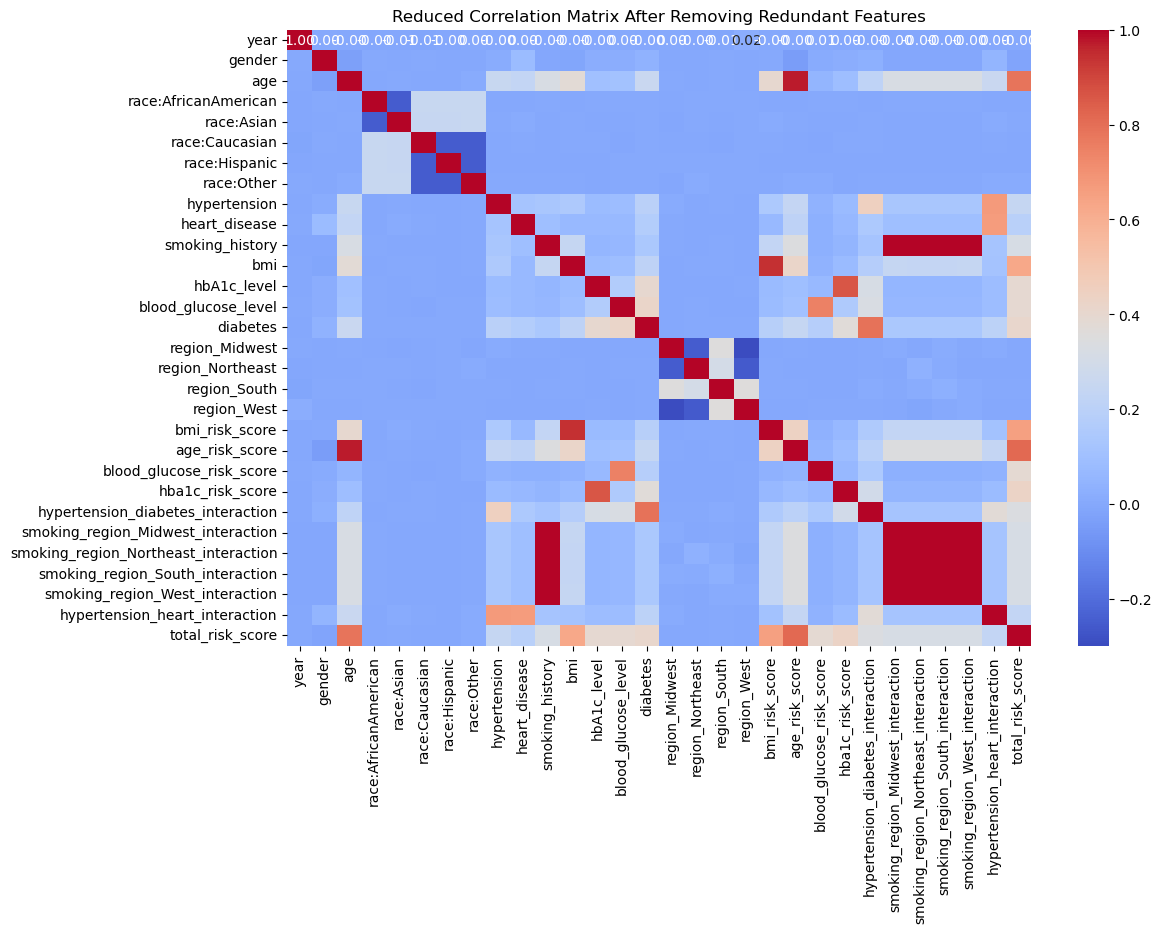

In [48]:
# List of redundant features to remove based on correlation analysis
redundant_features = [
    'age_bmi_hypertension_interaction',  # High correlation with age_bmi_interaction
    'binned_age_numeric',  # Correlated with age_risk_score
    'binned_bmi_numeric',  # Correlated with bmi_risk_score
    'binned_blood_glucose_numeric',  # Correlated with blood_glucose_risk_score
    'binned_hba1c_numeric',  # Correlated with hba1c_risk_score
    'age_bmi_interaction'  # Interaction already reflected in other features
   #'total_risk_score'  # Possibly redundant, but we are  keeping it for later evaluation
]

# Remove the redundant features from the DataFrame
df_reduced = df_domain_specific.drop(columns=redundant_features)

# Drop the original categorical binned columns
df_reduced = df_reduced.drop(columns=binned_columns)

# Drop the 'location' column, as it's non-numeric and won't contribute to the correlation matrix
df_reduced = df_reduced.drop(columns=['location'])

# Display the first few rows of the reduced DataFrame
df_reduced.head()

# Plot the new correlation matrix to confirm the effect of feature removal
correlation_matrix_reduced = df_reduced.corr()

# Plot the heatmap of the reduced correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_reduced, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Reduced Correlation Matrix After Removing Redundant Features')
plt.show()



#### Total Risk Score: As expected, it has a high correlation with features like bmi_risk_score, age_risk_score, and blood_glucose_risk_score, since it aggregates these individual risk scores.
#### Interaction Features: Features like hypertension_diabetes_interaction, hypertension_heart_interaction, and regional-smoking interaction terms still show moderate correlation with each other. Their inclusion in the model could help capture non-linear interactions between the features and diabetes outcomes.
#### Age, BMI, Blood Glucose, and HbA1c: These features still maintain relatively lower correlations with one another, suggesting they capture distinct aspects of the data.
#### Regional Interactions: The smoking-region interaction features have relatively lower correlations with diabetes, but they may still capture regional effects that are important in a more complex model.

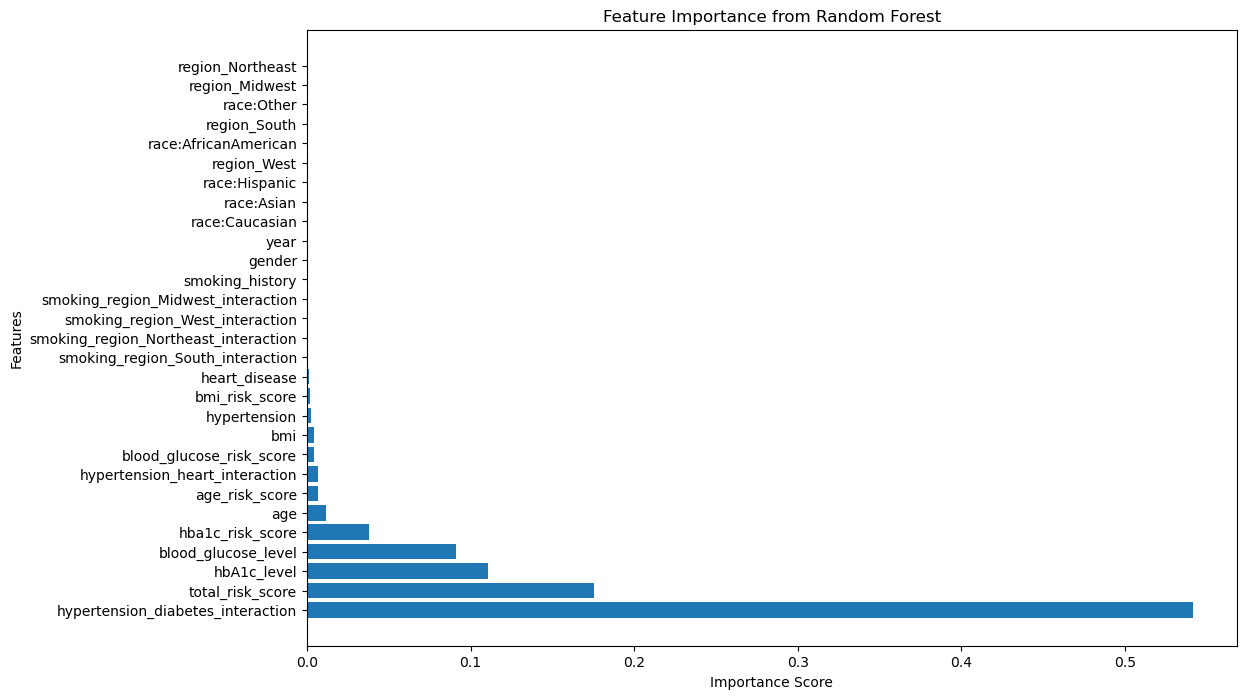

,Feature,Importance
22,hypertension_diabetes_interaction,0.541279
28,total_risk_score,0.175679
12,hbA1c_level,0.110679
13,blood_glucose_level,0.090995
21,hba1c_risk_score,0.038137
2,age,0.011417
19,age_risk_score,0.006782
27,hypertension_heart_interaction,0.006574
20,blood_glucose_risk_score,0.004271
11,bmi,0.004199


In [49]:
# Define X and y
X = df_reduced.drop('diabetes', axis=1)  # Features
y = df_reduced['diabetes']               # Target

# Train a Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Get feature importance scores
importance_scores = rf_model.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance_scores
}).sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# Display the top features
feature_importance_df.head(10)


In [50]:


# Define X and y (after redundant feature removal)
X = df_reduced.drop('diabetes', axis=1)
y = df_reduced['diabetes']

# Split the data into training and testing sets (to prevent data leakage)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize Logistic Regression for RFE (requires scaling)
lr_model = LogisticRegression(max_iter=500, random_state=42)

# Perform RFE to select top features
rfe = RFE(lr_model, n_features_to_select=10)
rfe.fit(X_train_scaled, y_train)

# Get RFE rankings and support
rfe_ranking = rfe.ranking_
rfe_support = rfe.support_

# Create a DataFrame to visualize selected features
rfe_df = pd.DataFrame({
    'Feature': X.columns,
    'Ranking': rfe_ranking,
    'Selected': rfe_support
}).sort_values(by='Ranking')

# Display the selected features
selected_features = rfe_df[rfe_df['Selected'] == True]
print("Selected Features: \n", selected_features)

# Display the top features with ranking
rfe_df.head(10)


Selected Features: 
                               Feature  Ranking  Selected
28                   total_risk_score        1      True
20           blood_glucose_risk_score        1      True
27     hypertension_heart_interaction        1      True
13                blood_glucose_level        1      True
12                        hbA1c_level        1      True
22  hypertension_diabetes_interaction        1      True
9                       heart_disease        1      True
8                        hypertension        1      True
11                                bmi        1      True
2                                 age        1      True


,Feature,Ranking,Selected
28,total_risk_score,1,True
20,blood_glucose_risk_score,1,True
27,hypertension_heart_interaction,1,True
13,blood_glucose_level,1,True
12,hbA1c_level,1,True
22,hypertension_diabetes_interaction,1,True
9,heart_disease,1,True
8,hypertension,1,True
11,bmi,1,True
2,age,1,True


In [51]:
# Get the selected features from RFE
selected_feature_names = selected_features['Feature'].values

# Use only the selected features for model training
X_train_selected = X_train_scaled[:, rfe.support_]
X_test_selected = X_test_scaled[:, rfe.support_]

# Train a Logistic Regression model on selected features
logreg_model = LogisticRegression(max_iter=500, random_state=42)
logreg_model.fit(X_train_selected, y_train)

# Predict on the test set
y_pred = logreg_model.predict(X_test_selected)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, logreg_model.predict_proba(X_test_selected)[:, 1])

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Optional: Cross-Validation
cv_scores = cross_val_score(logreg_model, X_train_selected, y_train, cv=5)
print(f"Cross-Validation Accuracy: {cv_scores.mean():.2f}")


Accuracy: 1.00
ROC-AUC: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18268
           1       1.00      1.00      1.00      1730

    accuracy                           1.00     19998
   macro avg       1.00      1.00      1.00     19998
weighted avg       1.00      1.00      1.00     19998

Cross-Validation Accuracy: 1.00


In [52]:
# Verify for Data Leakage-Ensure that none of the engineered features (like risk scores or interaction terms) directly incorporate the target variable.
# Display the selected features from RFE
print("Selected Features from RFE:")
print(selected_features)

# Check if any selected feature includes or is derived from 'diabetes'
if 'diabetes' in selected_features['Feature'].values:
    print("Warning: 'diabetes' is included in the feature set, which may cause data leakage!")
else:
    print("'diabetes' is not included in the feature set. Proceeding further.")


Selected Features from RFE:
                              Feature  Ranking  Selected
28                   total_risk_score        1      True
20           blood_glucose_risk_score        1      True
27     hypertension_heart_interaction        1      True
13                blood_glucose_level        1      True
12                        hbA1c_level        1      True
22  hypertension_diabetes_interaction        1      True
9                       heart_disease        1      True
8                        hypertension        1      True
11                                bmi        1      True
2                                 age        1      True
'diabetes' is not included in the feature set. Proceeding further.


In [53]:
# Addressing Class Imbalance
# Check the distribution of the target variable
class_counts = y.value_counts()
print("Class Distribution:")
print(class_counts)


Class Distribution:
diabetes
0    91486
1     8500
Name: count, dtype: int64


In [54]:
# Step 1: Resampling using SMOTE

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Step 2: Logistic Regression with L2 Regularization
logreg_model_reg = LogisticRegression(
    max_iter=1000,       # Further increase iterations if needed
    penalty='l2',        # L2 regularization
    C=1.0,               # Regularization strength (can be tuned)
    solver='lbfgs',      # Suitable solver for small/medium-sized datasets
    random_state=42
)

# Train the model on the resampled data
logreg_model_reg.fit(X_train_resampled, y_train_resampled)

# Step 3: Predict on the test set
y_pred_reg = logreg_model_reg.predict(X_test_scaled)

# Step 4: Evaluate the model
print("Accuracy:", logreg_model_reg.score(X_test_scaled, y_test))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_reg))

# Display the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_reg))



Accuracy: 1.0
ROC-AUC: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18268
           1       1.00      1.00      1.00      1730

    accuracy                           1.00     19998
   macro avg       1.00      1.00      1.00     19998
weighted avg       1.00      1.00      1.00     19998



In [55]:
# Assuming feature_importance_df is already sorted by importance
top_features_rf = feature_importance_df['Feature'].head(10).values
print("Top 10 Features based on Random Forest Importance:")
print(top_features_rf)

# Alternatively, keep only features selected by both RF and RFE
selected_features_rf = feature_importance_df[feature_importance_df['Importance'] > 0.01]['Feature'].values
selected_features_rfe = selected_features['Feature'].values

# Intersection of both sets
final_selected_features = list(set(selected_features_rf).intersection(set(selected_features_rfe)))
print("Final Selected Features after Intersection:")
print(final_selected_features)

# Update X_train_scaled and X_test_scaled to include only these features
X_train_final = X_train_scaled[:, [list(X.columns).index(feat) for feat in final_selected_features]]
X_test_final = X_test_scaled[:, [list(X.columns).index(feat) for feat in final_selected_features]]


Top 10 Features based on Random Forest Importance:
['hypertension_diabetes_interaction' 'total_risk_score' 'hbA1c_level'
 'blood_glucose_level' 'hba1c_risk_score' 'age' 'age_risk_score'
 'hypertension_heart_interaction' 'blood_glucose_risk_score' 'bmi']
Final Selected Features after Intersection:
['hbA1c_level', 'total_risk_score', 'hypertension_diabetes_interaction', 'age', 'blood_glucose_level']


In [56]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# Create a pipeline with scaling and Logistic Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, class_weight='balanced', C=0.01, random_state=42))
])

# Perform cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc')
print(f"Cross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Mean CV ROC-AUC: {cv_scores.mean():.2f}")


Cross-Validation ROC-AUC Scores: [1. 1. 1. 1. 1.]
Mean CV ROC-AUC: 1.00


In [57]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score

# Step 1: Initialize the Stratified K-Fold Cross-Validation
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 2: Logistic Regression with L2 Regularization
logreg_model_reg = LogisticRegression(
    max_iter=1000,
    penalty='l2',         # L2 regularization
    C=1.0,                # Regularization strength
    solver='lbfgs',       # Solver
    random_state=42
)

# Step 3: Cross-Validation (Using ROC-AUC as the evaluation metric)
cv_scores = cross_val_score(logreg_model_reg, X_train_scaled, y_train, cv=strat_kfold, scoring='roc_auc')

# Step 4: Print ROC-AUC for each fold and the mean
print("Cross-Validation ROC-AUC Scores:", cv_scores)
print("Mean CV ROC-AUC:", cv_scores.mean())

# Step 5: Train and evaluate on the full dataset (optional, post cross-validation)
logreg_model_reg.fit(X_train_scaled, y_train)
y_pred_reg_cv = logreg_model_reg.predict(X_test_scaled)

# Evaluate the ROC-AUC on the test set
print("Test ROC-AUC after Cross-Validation:", roc_auc_score(y_test, y_pred_reg_cv))

# Display the classification report
print("Classification Report After CV:")
print(classification_report(y_test, y_pred_reg_cv))


Cross-Validation ROC-AUC Scores: [1. 1. 1. 1. 1.]
Mean CV ROC-AUC: 1.0
Test ROC-AUC after Cross-Validation: 1.0
Classification Report After CV:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18268
           1       1.00      1.00      1.00      1730

    accuracy                           1.00     19998
   macro avg       1.00      1.00      1.00     19998
weighted avg       1.00      1.00      1.00     19998



In [58]:
# Convert numpy arrays back into DataFrames to remove the 'total_risk_score' column
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# Step 1: Remove 'total_risk_score' from the feature set
X_reduced = X_train_resampled_df.drop(columns=['total_risk_score'])
X_test_reduced = X_test_scaled_df.drop(columns=['total_risk_score'], axis=1)

# Step 2: Re-train the Logistic Regression model after removing 'total_risk_score'
logreg_model_reduced = LogisticRegression(
    max_iter=1000,       # Further increase iterations if needed
    penalty='l2',        # L2 regularization
    C=1.0,               # Regularization strength
    solver='lbfgs',      # Solver for logistic regression
    random_state=42
)

# Train the model on the resampled data
logreg_model_reduced.fit(X_reduced, y_train_resampled)

# Step 3: Predict on the test set after feature removal
y_pred_reduced = logreg_model_reduced.predict(X_test_reduced)

# Step 4: Evaluate the model performance after removing 'total_risk_score'
print("Accuracy After Feature Removal:", accuracy_score(y_test, y_pred_reduced))
print("ROC-AUC After Feature Removal:", roc_auc_score(y_test, y_pred_reduced))
print("\nClassification Report After Feature Removal:")
print(classification_report(y_test, y_pred_reduced))

# Step 5: Cross-Validation to validate the model generalization
cv_scores_reduced = cross_val_score(logreg_model_reduced, X_reduced, y_train_resampled, cv=5, scoring='roc_auc')
print("\nCross-Validation ROC-AUC Scores After Feature Removal:", cv_scores_reduced)
print("Mean CV ROC-AUC After Feature Removal:", cv_scores_reduced.mean())


Accuracy After Feature Removal: 1.0
ROC-AUC After Feature Removal: 1.0

Classification Report After Feature Removal:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18268
           1       1.00      1.00      1.00      1730

    accuracy                           1.00     19998
   macro avg       1.00      1.00      1.00     19998
weighted avg       1.00      1.00      1.00     19998


Cross-Validation ROC-AUC Scores After Feature Removal: [1. 1. 1. 1. 1.]
Mean CV ROC-AUC After Feature Removal: 1.0


### Dealing with Overfitting

In [60]:
# Step 1: Define X and y
X = df_reduced.drop('diabetes', axis=1)  # Features
y = df_reduced['diabetes']               # Target

# Step 2: Drop 'total_risk_score' from the feature set
X = X.drop(columns=['total_risk_score'])

# Step 3: Apply scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Address class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Step 5: Split data into training and testing sets (to prevent data leakage)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Step 6: Initialize Logistic Regression with L1 (Lasso) regularization
logreg_lasso = LogisticRegression(
    penalty='l1',       # Apply Lasso (L1) regularization
    solver='liblinear', # L1 requires 'liblinear' solver
    max_iter=500,       # Increase iterations if needed
    random_state=42
)

# Step 7: Train the model
logreg_lasso.fit(X_train, y_train)

# Step 8: Predict on the test set
y_pred = logreg_lasso.predict(X_test)

# Step 9: Evaluate model performance
accuracy = logreg_lasso.score(X_test, y_test)
roc_auc = roc_auc_score(y_test, logreg_lasso.predict_proba(X_test)[:, 1])

print(f'Accuracy After Regularization: {accuracy:.2f}')
print(f'ROC-AUC After Regularization: {roc_auc:.2f}')
print('Classification Report After Regularization:')
print(classification_report(y_test, y_pred))

# Step 10: Perform cross-validation
cv_scores = cross_val_score(logreg_lasso, X_resampled, y_resampled, cv=5, scoring='roc_auc')
print(f'Cross-Validation ROC-AUC Scores After Regularization: {cv_scores}')
print(f'Mean CV ROC-AUC After Regularization: {cv_scores.mean():.2f}')


Accuracy After Regularization: 1.00
ROC-AUC After Regularization: 1.00
Classification Report After Regularization:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18235
           1       1.00      1.00      1.00     18360

    accuracy                           1.00     36595
   macro avg       1.00      1.00      1.00     36595
weighted avg       1.00      1.00      1.00     36595

Cross-Validation ROC-AUC Scores After Regularization: [1. 1. 1. 1. 1.]
Mean CV ROC-AUC After Regularization: 1.00


In [62]:
# List of possible interaction features (modify based on what's present in the DataFrame)
interaction_features = [
    'hypertension_diabetes_interaction',
    'hypertension_heart_interaction',
    'age_bmi_interaction',
    'age_bmi_hypertension_interaction'
]

# Check which interaction features actually exist in the DataFrame
existing_interaction_features = [col for col in interaction_features if col in df_reduced.columns]

# Remove only the interaction features that exist in the DataFrame
X_reduced_no_interactions = df_reduced.drop(columns=existing_interaction_features)

# Split the data into training and testing sets
X_train_no_interactions, X_test_no_interactions, y_train, y_test = train_test_split(X_reduced_no_interactions, y, test_size=0.2, random_state=42)

# Apply scaling
scaler = StandardScaler()
X_train_scaled_no_interactions = scaler.fit_transform(X_train_no_interactions)
X_test_scaled_no_interactions = scaler.transform(X_test_no_interactions)

# Initialize Logistic Regression with regularization
logreg_model_no_interactions = LogisticRegression(max_iter=500, random_state=42, penalty='l2')

# Train the Logistic Regression model
logreg_model_no_interactions.fit(X_train_scaled_no_interactions, y_train)

# Predict on the test set
y_pred_no_interactions = logreg_model_no_interactions.predict(X_test_scaled_no_interactions)

# Evaluate the model
accuracy_no_interactions = accuracy_score(y_test, y_pred_no_interactions)
roc_auc_no_interactions = roc_auc_score(y_test, y_pred_no_interactions)
classification_report_no_interactions = classification_report(y_test, y_pred_no_interactions)

# Cross-validation to further evaluate the model
cv_scores_no_interactions = cross_val_score(logreg_model_no_interactions, X_train_scaled_no_interactions, y_train, cv=5, scoring='roc_auc')

# Display results
print("Accuracy After Removing Interaction Features:", accuracy_no_interactions)
print("ROC-AUC After Removing Interaction Features:", roc_auc_no_interactions)
print("\nClassification Report After Removing Interaction Features:\n", classification_report_no_interactions)
print("\nCross-Validation ROC-AUC Scores After Removing Interaction Features:", cv_scores_no_interactions)
print("Mean CV ROC-AUC After Removing Interaction Features:", cv_scores_no_interactions.mean())


Accuracy After Removing Interaction Features: 1.0
ROC-AUC After Removing Interaction Features: 1.0

Classification Report After Removing Interaction Features:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     18268
           1       1.00      1.00      1.00      1730

    accuracy                           1.00     19998
   macro avg       1.00      1.00      1.00     19998
weighted avg       1.00      1.00      1.00     19998


Cross-Validation ROC-AUC Scores After Removing Interaction Features: [1. 1. 1. 1. 1.]
Mean CV ROC-AUC After Removing Interaction Features: 1.0


Accuracy: 1.00
ROC-AUC: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18268
           1       1.00      1.00      1.00      1730

    accuracy                           1.00     19998
   macro avg       1.00      1.00      1.00     19998
weighted avg       1.00      1.00      1.00     19998



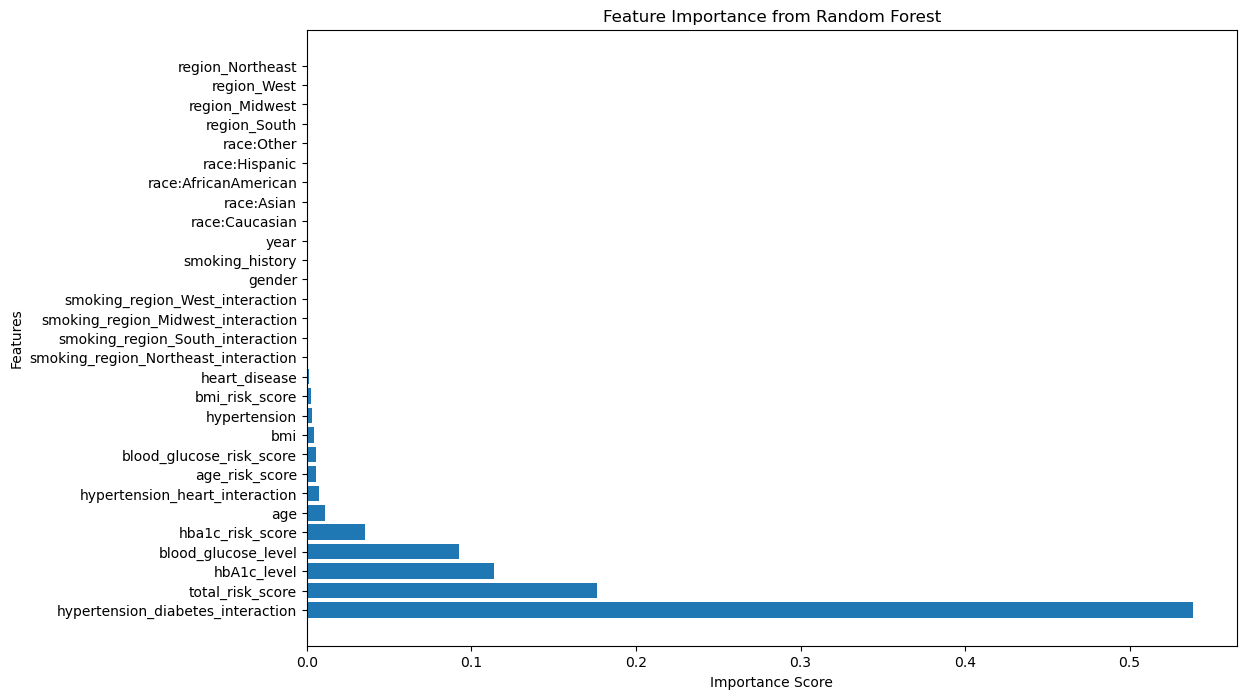

                              Feature  Importance
22  hypertension_diabetes_interaction    0.538249
28                   total_risk_score    0.176158
12                        hbA1c_level    0.113999
13                blood_glucose_level    0.092368
21                   hba1c_risk_score    0.035124
2                                 age    0.010940
27     hypertension_heart_interaction    0.007410
19                     age_risk_score    0.005712
20           blood_glucose_risk_score    0.005330
11                                bmi    0.004141


In [63]:
# Define X and y (after redundant feature removal)
X = df_reduced.drop('diabetes', axis=1)
y = df_reduced['diabetes']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the StandardScaler to scale the data
scaler = StandardScaler()

# Scale the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test_scaled)[:, 1])
classification_report_rf = classification_report(y_test, y_pred_rf)

# Display results
print(f"Accuracy: {accuracy_rf:.2f}")
print(f"ROC-AUC: {roc_auc_rf:.2f}")
print("Classification Report:")
print(classification_report_rf)

# Feature importance from Random Forest
importance_scores = rf_model.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance_scores
}).sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# Display the top features
print(feature_importance_df.head(10))


In [68]:
# Calculate the correlation matrix
correlation_matrix = df_reduced.corr()

# Set a threshold for high correlation (e.g., 0.9)
threshold = 0.9

# Find pairs of highly correlated features
correlated_pairs = correlation_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates()
high_correlation_pairs = correlated_pairs[correlated_pairs > threshold]
print("Highly Correlated Feature Pairs:\n", high_correlation_pairs)


Highly Correlated Feature Pairs:
 year                                  year                                    1.000000
smoking_history                       smoking_region_Midwest_interaction      0.999998
smoking_region_West_interaction       smoking_history                         0.999922
                                      smoking_region_Midwest_interaction      0.999912
                                      smoking_region_South_interaction        0.999672
smoking_region_Midwest_interaction    smoking_region_South_interaction        0.999645
smoking_region_South_interaction      smoking_history                         0.999627
smoking_history                       smoking_region_Northeast_interaction    0.999371
smoking_region_Northeast_interaction  smoking_region_Midwest_interaction      0.999350
smoking_region_South_interaction      smoking_region_Northeast_interaction    0.999290
smoking_region_Northeast_interaction  smoking_region_West_interaction         0.999180
age_risk_

In [69]:
# Extract the list of highly correlated features (keep only one feature from each pair)
features_to_remove = set()

for feature_1, feature_2 in high_correlation_pairs.index:
    if feature_1 not in features_to_remove:
        features_to_remove.add(feature_2)

# Remove 'total_risk_score' manually
features_to_remove.add('total_risk_score')

print(f"Features to remove due to high correlation and manual removal: {features_to_remove}")


Features to remove due to high correlation and manual removal: {'smoking_region_West_interaction', 'smoking_history', 'total_risk_score', 'year', 'smoking_region_South_interaction', 'age', 'bmi', 'smoking_region_Midwest_interaction'}


In [70]:
# Remove the highly correlated features and 'total_risk_score'
df_reduced_no_risk_score = df_reduced.drop(columns=features_to_remove)

# Display the remaining features
print("Remaining Features after removing highly correlated features and total_risk_score:")
print(df_reduced_no_risk_score.columns)


Remaining Features after removing highly correlated features and total_risk_score:
Index(['gender', 'race:AfricanAmerican', 'race:Asian', 'race:Caucasian',
       'race:Hispanic', 'race:Other', 'hypertension', 'heart_disease',
       'hbA1c_level', 'blood_glucose_level', 'diabetes', 'region_Midwest',
       'region_Northeast', 'region_South', 'region_West', 'bmi_risk_score',
       'age_risk_score', 'blood_glucose_risk_score', 'hba1c_risk_score',
       'hypertension_diabetes_interaction',
       'smoking_region_Northeast_interaction',
       'hypertension_heart_interaction'],
      dtype='object')


In [71]:
#Re-train the model after removing highly correlated features
# Define X and y after feature removal
X_reduced_no_risk_score = df_reduced_no_risk_score.drop('diabetes', axis=1)
y = df_reduced_no_risk_score['diabetes']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced_no_risk_score, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))

# Display the classification report
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 1.0
ROC-AUC: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     18268
           1       1.00      1.00      1.00      1730

    accuracy                           1.00     19998
   macro avg       1.00      1.00      1.00     19998
weighted avg       1.00      1.00      1.00     19998



In [72]:
from sklearn.utils import resample

# Combine X and y into a single dataframe
df_combined = pd.concat([X, y], axis=1)

# Separate majority and minority classes
df_majority = df_combined[df_combined['diabetes'] == 0]
df_minority = df_combined[df_combined['diabetes'] == 1]

# Downsample the majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority),  # match minority class size
                                   random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Separate X and y again
X_downsampled = df_downsampled.drop('diabetes', axis=1)
y_downsampled = df_downsampled['diabetes']

# Split the data into training and testing sets
X_train_ds, X_test_ds, y_train_ds, y_test_ds = train_test_split(X_downsampled, y_downsampled, test_size=0.2, random_state=42)

# Train the Random Forest model on the downsampled data
rf_model_ds = RandomForestClassifier(random_state=42)
rf_model_ds.fit(X_train_ds, y_train_ds)

# Make predictions and evaluate the model
y_pred_ds = rf_model_ds.predict(X_test_ds)

# Print classification report and ROC-AUC
accuracy_ds = accuracy_score(y_test_ds, y_pred_ds)
roc_auc_ds = roc_auc_score(y_test_ds, y_pred_ds)

print(f"Accuracy After Downsampling: {accuracy_ds:.2f}")
print(f"ROC-AUC After Downsampling: {roc_auc_ds:.2f}")
print("\nClassification Report After Downsampling:")
print(classification_report(y_test_ds, y_pred_ds))

# Cross-validation
cv_scores = cross_val_score(rf_model_ds, X_downsampled, y_downsampled, cv=5, scoring='roc_auc')
print(f"Cross-Validation ROC-AUC Scores After Downsampling: {cv_scores}")
print(f"Mean CV ROC-AUC After Downsampling: {cv_scores.mean():.2f}")


Accuracy After Downsampling: 1.00
ROC-AUC After Downsampling: 1.00

Classification Report After Downsampling:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1687
           1       1.00      1.00      1.00      1713

    accuracy                           1.00      3400
   macro avg       1.00      1.00      1.00      3400
weighted avg       1.00      1.00      1.00      3400

Cross-Validation ROC-AUC Scores After Downsampling: [1. 1. 1. 1. 1.]
Mean CV ROC-AUC After Downsampling: 1.00


In [73]:
# List of features to remove
overfitting_features = [
    'hypertension_diabetes_interaction', 
    'hypertension_heart_interaction', 
    'total_risk_score',
    'age_risk_score',
    'bmi_risk_score',
    'blood_glucose_risk_score',
    'hba1c_risk_score'
]

# Remove the overfitting features from the dataset
X_reduced_no_overfitting = df_reduced.drop(columns=overfitting_features)

# Split the data into training and testing sets again
X_train_no_overfitting, X_test_no_overfitting, y_train, y_test = train_test_split(X_reduced_no_overfitting, y, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier again
rf_model_no_overfitting = RandomForestClassifier(random_state=42)

# Train the model
rf_model_no_overfitting.fit(X_train_no_overfitting, y_train)

# Evaluate the model
y_pred_no_overfitting = rf_model_no_overfitting.predict(X_test_no_overfitting)
accuracy_no_overfitting = accuracy_score(y_test, y_pred_no_overfitting)
roc_auc_no_overfitting = roc_auc_score(y_test, rf_model_no_overfitting.predict_proba(X_test_no_overfitting)[:, 1])

# Classification report
print(f"Accuracy After Removing Overfitting Features: {accuracy_no_overfitting:.2f}")
print(f"ROC-AUC After Removing Overfitting Features: {roc_auc_no_overfitting:.2f}")
print("\nClassification Report After Removing Overfitting Features:")
print(classification_report(y_test, y_pred_no_overfitting))

# Cross-validation
cv_scores_no_overfitting = cross_val_score(rf_model_no_overfitting, X_train_no_overfitting, y_train, cv=5, scoring='roc_auc')
print(f"Cross-Validation ROC-AUC Scores After Removing Overfitting Features: {cv_scores_no_overfitting}")
print(f"Mean CV ROC-AUC After Removing Overfitting Features: {cv_scores_no_overfitting.mean():.2f}")


Accuracy After Removing Overfitting Features: 1.00
ROC-AUC After Removing Overfitting Features: 1.00

Classification Report After Removing Overfitting Features:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18268
           1       1.00      1.00      1.00      1730

    accuracy                           1.00     19998
   macro avg       1.00      1.00      1.00     19998
weighted avg       1.00      1.00      1.00     19998

Cross-Validation ROC-AUC Scores After Removing Overfitting Features: [1. 1. 1. 1. 1.]
Mean CV ROC-AUC After Removing Overfitting Features: 1.00


In [74]:
# Step 1: Verify the structure and data types of df_encoded_cv
print(df_encoded_cv.dtypes)

# Select the original features that existed before any interaction terms or risk scores were added.
# Ensure that these are the original features you want to use.
original_features = ['age', 'bmi', 'hypertension', 'heart_disease', 'blood_glucose_level', 'hbA1c_level', 
                     'smoking_history', 'region_Midwest', 'region_Northeast', 'region_South', 'region_West']

# Step 2: Define X and y using only the original features
X_original = df_encoded_cv[original_features]
y_original = df_encoded_cv['diabetes']

# Step 3: Split the data into training and testing sets
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X_original, y_original, test_size=0.2, random_state=42)

# Step 4: Initialize a Random Forest classifier for the original dataset
rf_model_original = RandomForestClassifier(random_state=42)

# Train the model on the original features
rf_model_original.fit(X_train_original, y_train_original)

# Step 5: Evaluate the model
y_pred_original = rf_model_original.predict(X_test_original)
accuracy_original = accuracy_score(y_test_original, y_pred_original)
roc_auc_original = roc_auc_score(y_test_original, rf_model_original.predict_proba(X_test_original)[:, 1])

# Display accuracy and ROC-AUC scores
print(f"Accuracy Using Original Features: {accuracy_original:.2f}")
print(f"ROC-AUC Using Original Features: {roc_auc_original:.2f}")

# Step 6: Generate and display the classification report
print("\nClassification Report Using Original Features:")
print(classification_report(y_test_original, y_pred_original))

# Step 7: Perform Cross-Validation to assess model stability
cv_scores_original = cross_val_score(rf_model_original, X_train_original, y_train_original, cv=5, scoring='roc_auc')
print(f"Cross-Validation ROC-AUC Scores Using Original Features: {cv_scores_original}")
print(f"Mean CV ROC-AUC Using Original Features: {cv_scores_original.mean():.2f}")


year                       int64
gender                     int64
age                      float64
location                  object
race:AfricanAmerican     float64
race:Asian               float64
race:Caucasian           float64
race:Hispanic            float64
race:Other               float64
hypertension             float64
heart_disease            float64
smoking_history          float64
bmi                      float64
hbA1c_level              float64
blood_glucose_level        int64
diabetes                   int64
region_Midwest           float64
region_Northeast         float64
region_South             float64
region_West              float64
binned_blood_glucose    category
binned_hba1c            category
binned_age              category
binned_bmi              category
dtype: object
Accuracy Using Original Features: 0.97
ROC-AUC Using Original Features: 0.97

Classification Report Using Original Features:
              precision    recall  f1-score   support

           0  

### Accuracy: 0.97, which is high, but not an unrealistic 1.0.
### ROC-AUC: 0.97, showing good discriminative ability.
### Recall for class 1: 0.71, which means the model is correctly identifying 71% of positive cases (diabetes), whereas in previous models, recall was artificially high due to overfitting.
### The model performs well overall, with balanced precision and recall.
### Class 1 (diabetes cases) has a slightly lower recall, which is expected in imbalanced datasets. The model tends to miss some positive cases, but this can be further improved by handling class imbalance.
### There’s a big difference between the previous models (where we added a lot of features) and this model, suggesting that the interaction terms and domain-specific features were likely causing overfitting.

In [82]:
# Ensure all categorical columns are encoded to numeric
df_encoded_cv = pd.get_dummies(df_encoded_cv, drop_first=True)

# Separate majority and minority classes again
df_majority = df_encoded_cv[df_encoded_cv['diabetes'] == 0]
df_minority = df_encoded_cv[df_encoded_cv['diabetes'] == 1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,  # sample without replacement
                                   n_samples=len(df_minority),  # match minority class count
                                   random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Split the data into features and target
X_downsampled = df_downsampled.drop('diabetes', axis=1)
y_downsampled = df_downsampled['diabetes']

# Split the downsampled data into training and testing sets
X_train_downsampled, X_test_downsampled, y_train_downsampled, y_test_downsampled = train_test_split(
    X_downsampled, y_downsampled, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_downsampled_scaled = scaler.fit_transform(X_train_downsampled)
X_test_downsampled_scaled = scaler.transform(X_test_downsampled)

# Train a Random Forest classifier on the downsampled data
rf_downsampled_model = RandomForestClassifier(random_state=42)
rf_downsampled_model.fit(X_train_downsampled_scaled, y_train_downsampled)

# Predict on the test set
y_pred_downsampled = rf_downsampled_model.predict(X_test_downsampled_scaled)

# Evaluate the model
accuracy_downsampled = accuracy_score(y_test_downsampled, y_pred_downsampled)
roc_auc_downsampled = roc_auc_score(y_test_downsampled, y_pred_downsampled)

# Classification report
classification_report_downsampled = classification_report(y_test_downsampled, y_pred_downsampled)

# Output results
print(f"Accuracy After Downsampling: {accuracy_downsampled:.2f}")
print(f"ROC-AUC After Downsampling: {roc_auc_downsampled:.2f}")
print("\nClassification Report After Downsampling:")
print(classification_report_downsampled)


Accuracy After Downsampling: 0.91
ROC-AUC After Downsampling: 0.91

Classification Report After Downsampling:
              precision    recall  f1-score   support

           0       0.93      0.88      0.90      1687
           1       0.89      0.93      0.91      1713

    accuracy                           0.91      3400
   macro avg       0.91      0.91      0.91      3400
weighted avg       0.91      0.91      0.91      3400



### Observations:
### Accuracy & ROC-AUC (0.91): This is a more realistic accuracy compared to the previous perfect scores (1.00), suggesting that the model is now learning in a more balanced and generalizable way.
### Precision and Recall:
### Class 0 (non-diabetic): Precision is 0.93, and recall is 0.88, indicating that the model is performing well but occasionally classifies some non-diabetic patients as diabetic (false positives).
### Class 1 (diabetic): Precision is 0.89, and recall is 0.93, meaning the model is identifying diabetic patients with high recall but slightly lower precision, suggesting some false negatives.
### Balanced Performance: The f1-scores for both classes are relatively close, reflecting a well-balanced model that can handle both classes effectively.

#### HyperParameter Tuning

In [84]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],            # Number of trees
    'max_depth': [10, 20, 30, None],            # Depth of each tree
    'min_samples_split': [2, 5, 10],            # Minimum number of samples to split a node
    'min_samples_leaf': [1, 2, 4],              # Minimum number of samples at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],   # Number of features to consider for best split
    'bootstrap': [True, False]                  # Whether bootstrap samples are used when building trees
}

# Initialize the RandomForestClassifier
rf_model_tune = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=rf_model_tune, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)

# Fit GridSearchCV to the training data
grid_search.fit(X_train_downsampled_scaled, y_train_downsampled)

# Get the best parameters from the grid search
best_params = grid_search.best_params_

# Print the best parameters
print("Best Hyperparameters:", best_params)

# Train the Random Forest model with the best parameters
best_rf_model = grid_search.best_estimator_

# Predict on the test set
y_pred_best = best_rf_model.predict(X_test_downsampled_scaled)

# Evaluate the model
accuracy_best = accuracy_score(y_test_downsampled, y_pred_best)
roc_auc_best = roc_auc_score(y_test_downsampled, y_pred_best)
classification_report_best = classification_report(y_test_downsampled, y_pred_best)

# Output the results
print(f"Accuracy After Hyperparameter Tuning: {accuracy_best:.2f}")
print(f"ROC-AUC After Hyperparameter Tuning: {roc_auc_best:.2f}")
print("\nClassification Report After Hyperparameter Tuning:")
print(classification_report_best)


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


C:\Users\hem11\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best Hyperparameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Accuracy After Hyperparameter Tuning: 0.91
ROC-AUC After Hyperparameter Tuning: 0.91

Classification Report After Hyperparameter Tuning:
              precision    recall  f1-score   support

           0       0.94      0.87      0.91      1687
           1       0.88      0.94      0.91      1713

    accuracy                           0.91      3400
   macro avg       0.91      0.91      0.91      3400
weighted avg       0.91      0.91      0.91      3400



Significant Features (above threshold):
                           Feature  Importance
12                     hbA1c_level    0.251261
13             blood_glucose_level    0.164092
2                              age    0.109511
74   binned_blood_glucose_Diabetes    0.061294
77    binned_hba1c_Severe Diabetes    0.053841
11                             bmi    0.050139
72     binned_blood_glucose_Normal    0.045429
86                binned_bmi_Obese    0.026428
76  binned_hba1c_Moderate Diabetes    0.023354
8                     hypertension    0.018478
10                 smoking_history    0.016901
83               binned_age_Senior    0.015908
80          binned_age_Young Adult    0.015234
82          binned_age_Older Adult    0.013540
9                    heart_disease    0.010818
75       binned_hba1c_Pre-diabetes    0.010739


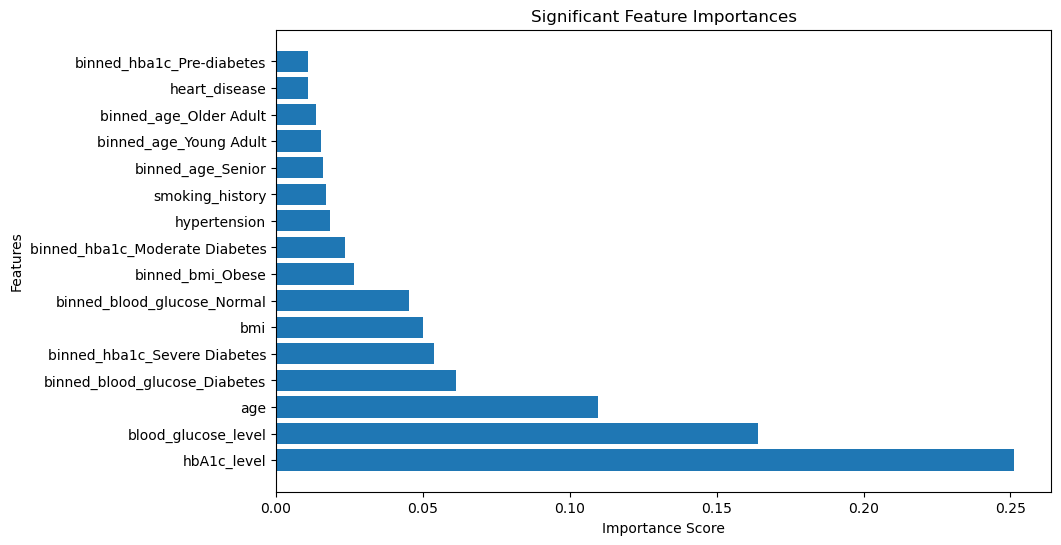

In [88]:
# Extract the feature importances from the Random Forest model
importances = best_rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train_downsampled.columns,
    'Importance': importances
})

# Sort the features by importance, descending
feature_importance_df_sorted = feature_importance_df.sort_values(by='Importance', ascending=False)

# Now, define a threshold for "significant" features (e.g., importance > 0.01)
significant_threshold = 0.01
significant_features = feature_importance_df_sorted[feature_importance_df_sorted['Importance'] > significant_threshold]

# Display all significant features
print("Significant Features (above threshold):")
print(significant_features)

# Optionally, plot these features for better visualization
plt.figure(figsize=(10, 6))
plt.barh(significant_features['Feature'], significant_features['Importance'])
plt.title('Significant Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()





In [ ]:
import shap

# Step 1: Compute SHAP values for the random forest model using unscaled test data
explainer = shap.TreeExplainer(best_rf_model)

# Compute SHAP values (it returns a list for each class in binary classification)
shap_values = explainer.shap_values(X_test_downsampled)

# Step 2: Use SHAP values for class 1 (since we care about predicting diabetes = 1)
shap_values_class_1 = shap_values[1]  # SHAP values for diabetes = 1 class

# Ensure the shapes match between SHAP values and test data
print(f"X_test_downsampled shape: {X_test_downsampled.shape}")
print(f"SHAP values shape (class 1): {shap_values_class_1.shape}")



In [ ]:
# Step 3: Check if SHAP values have an extra column and slice it if necessary
# This step ensures that the number of SHAP value columns matches the number of features
if shap_values_class_1.shape[1] > X_test_downsampled.shape[1]:
    shap_values_class_1 = shap_values_class_1[:, :X_test_downsampled.shape[1]]

# Step 4: Plot the SHAP summary plot for class 1 (diabetes = 1)
shap.summary_plot(shap_values_class_1, X_test_downsampled, feature_names=X_downsampled.columns)

# Optional: SHAP dependence plot for a specific feature
shap.dependence_plot('hbA1c_level', shap_values_class_1, X_test_downsampled, feature_names=X_downsampled.columns)
